# Сорревнование Kaggle. Цена домов

Целью данного соревноания является предсказание цены домов, то есть числовых значений. Перед нами стоит задача регрессии. Для решения данной задачи воспользуемся линейной регрессией, решающим деревом и случайным лесом. Также воспользуемся стекингом, бэггингом и градиентынм бустингом.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import clone
%matplotlib inline

## Выгрузка и предобработка данных

In [2]:
df = pd.read_csv('train.csv', index_col='Id')
df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

### Обработка пустых значений

In [4]:
na_col = df.isna().sum()[df.isna().sum() != 0].index
na_col

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

<AxesSubplot:>

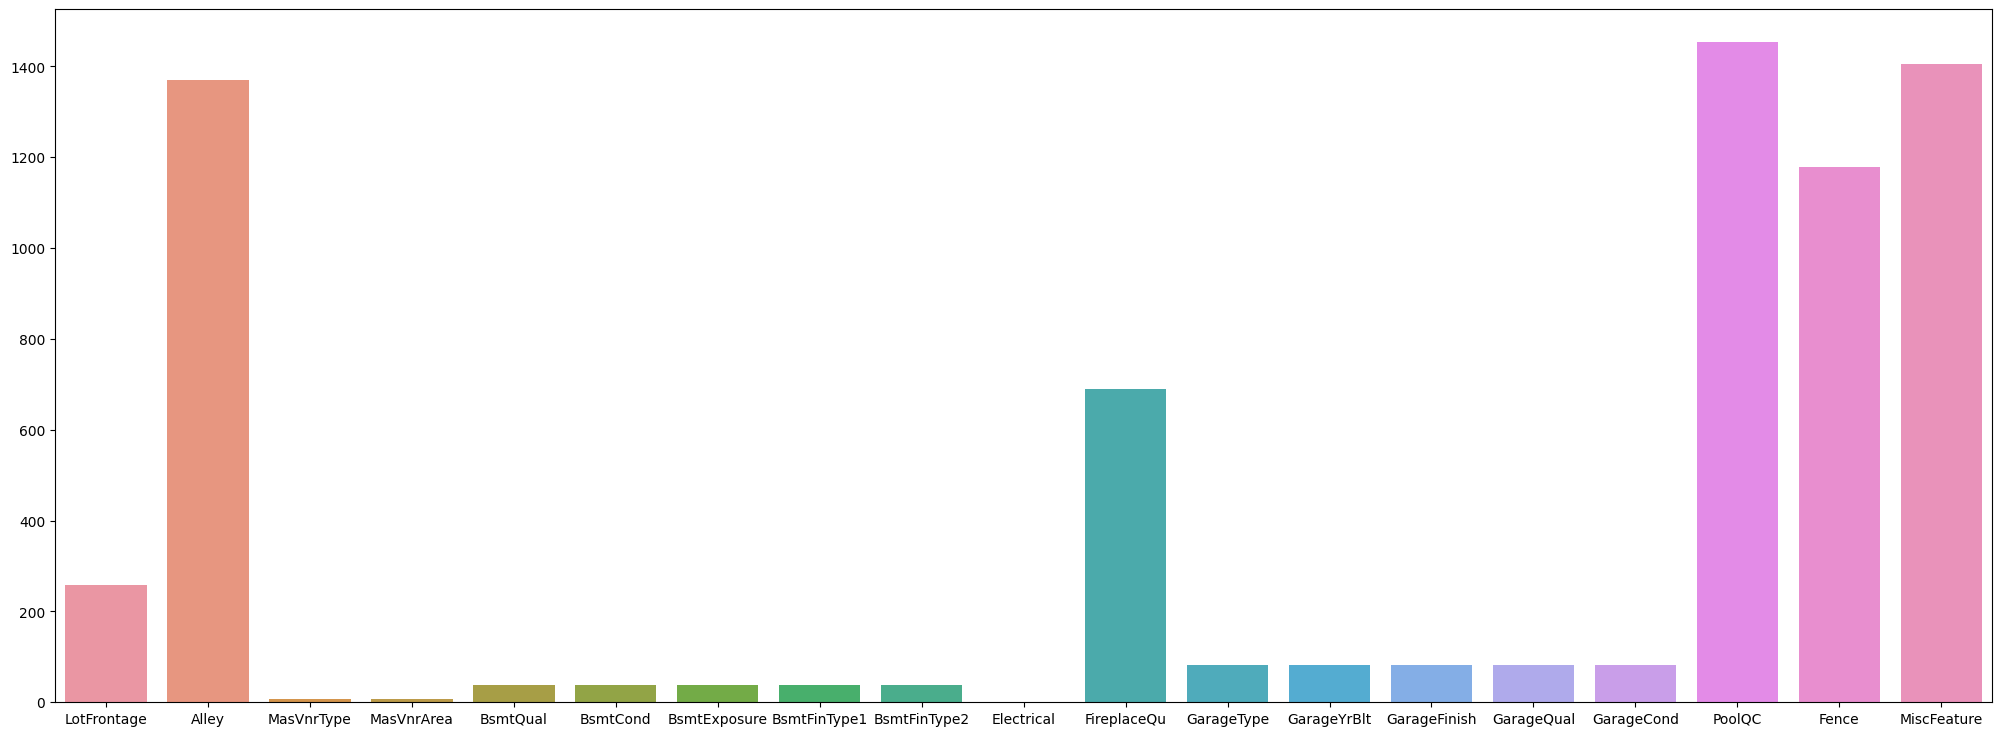

In [5]:
fig, ax = plt.subplots(figsize=(25, 9))
sns.barplot(x=na_col, y=df.isna().sum()[na_col], ax=ax)

По графику видно, что в датасете 19 столбцов, в которых присутствуют нулевые

In [6]:
nan_df = pd.DataFrame(np.array([df[na_col].isna().sum(), df[na_col].dtypes]).T, index=na_col, columns=['sum', 'types']).sort_values(by='sum', ascending=False)
nan_df

,sum,types
PoolQC,1453,object
MiscFeature,1406,object
Alley,1369,object
Fence,1179,object
FireplaceQu,690,object
LotFrontage,259,float64
GarageType,81,object
GarageYrBlt,81,float64
GarageFinish,81,object
GarageQual,81,object


Изучив каждый столбец был составлен список названий колонок, в которых ``NaN`` можно заменить на ``'Na'``

In [7]:
col_rep_nan = [ 'PoolQC',
                'MiscFeature',
                'Alley',
                'Fence',
                'FireplaceQu',
                'GarageType',
                'GarageFinish',
                'GarageQual',
                'GarageCond',
                'BsmtExposure',
                'BsmtFinType2',
                'BsmtFinType1',
                'BsmtCond',
                'BsmtQual' ]

In [8]:
df[col_rep_nan] = df[col_rep_nan].fillna('NA')

После замены значений в этих столбцах осталось два строковых столбца с пустыми значениями ``MasVnrType`` и  ``Electrical``

In [9]:
df[df['Electrical'].isna()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1380,80,RL,73.0,9735,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,5,2008,WD,Normal,167500


Так как в ``data_description.txt`` нет описания для ``NaN``, то мы удалим строчку с пустым значением

In [10]:
df.dropna(subset=['Electrical'], inplace=True)

Рассмотрим пропущенные значения в столбце ``MasVnrType``. По информации из ``data_description`` мы видим, что ``MasVnrType`` связан с ``MasVnrArea``. Если нет каменной кладки, то и не должно быть площади этой кладки

In [11]:
df[df['MasVnrType'].isna()][['MasVnrType', 'MasVnrArea']]

,MasVnrType,MasVnrArea
Id,,
235,NaN,NaN
530,NaN,NaN
651,NaN,NaN
937,NaN,NaN
974,NaN,NaN
978,NaN,NaN
1244,NaN,NaN
1279,NaN,NaN


In [12]:
df['MasVnrType'].fillna('NA', inplace=True)
df['MasVnrArea'].fillna(0, inplace=True)

Рассмотрим столбец ``GarageYrBlt``. Он отображает год постройки гаража, но у некоторых домов нет гаражей вообще. Поэтому значения ``NaN`` занулим

In [13]:
df['GarageYrBlt'].fillna(0, inplace=True)

Остался единственный столбец с пустыми значеняими - ``LotFrontage``

In [14]:
df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace=True)

In [15]:
df.isna().sum()[df.isna().sum() != 0].index

Index([], dtype='object')

### Выделим целевой столец

In [16]:
y = df['SalePrice']
df = df.drop(columns=['SalePrice'])

### Разделение на категориальные и числовые данные

In [17]:
cat_col = df.select_dtypes(include=object).columns
num_col = df.select_dtypes(exclude=object).columns

In [18]:
df_cat = df[cat_col]
df_num = df[num_col]

#### Обработка числовых данных

array([[<AxesSubplot:title={'center':'MSSubClass'}>,
        <AxesSubplot:title={'center':'LotFrontage'}>,
        <AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'OverallQual'}>,
        <AxesSubplot:title={'center':'OverallCond'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>],
       [<AxesSubplot:title={'center':'YearRemodAdd'}>,
        <AxesSubplot:title={'center':'MasVnrArea'}>,
        <AxesSubplot:title={'center':'BsmtFinSF1'}>,
        <AxesSubplot:title={'center':'BsmtFinSF2'}>,
        <AxesSubplot:title={'center':'BsmtUnfSF'}>,
        <AxesSubplot:title={'center':'TotalBsmtSF'}>],
       [<AxesSubplot:title={'center':'1stFlrSF'}>,
        <AxesSubplot:title={'center':'2ndFlrSF'}>,
        <AxesSubplot:title={'center':'LowQualFinSF'}>,
        <AxesSubplot:title={'center':'GrLivArea'}>,
        <AxesSubplot:title={'center':'BsmtFullBath'}>,
        <AxesSubplot:title={'center':'BsmtHalfBath'}>],
       [<AxesSubplot:title={'center':'Ful

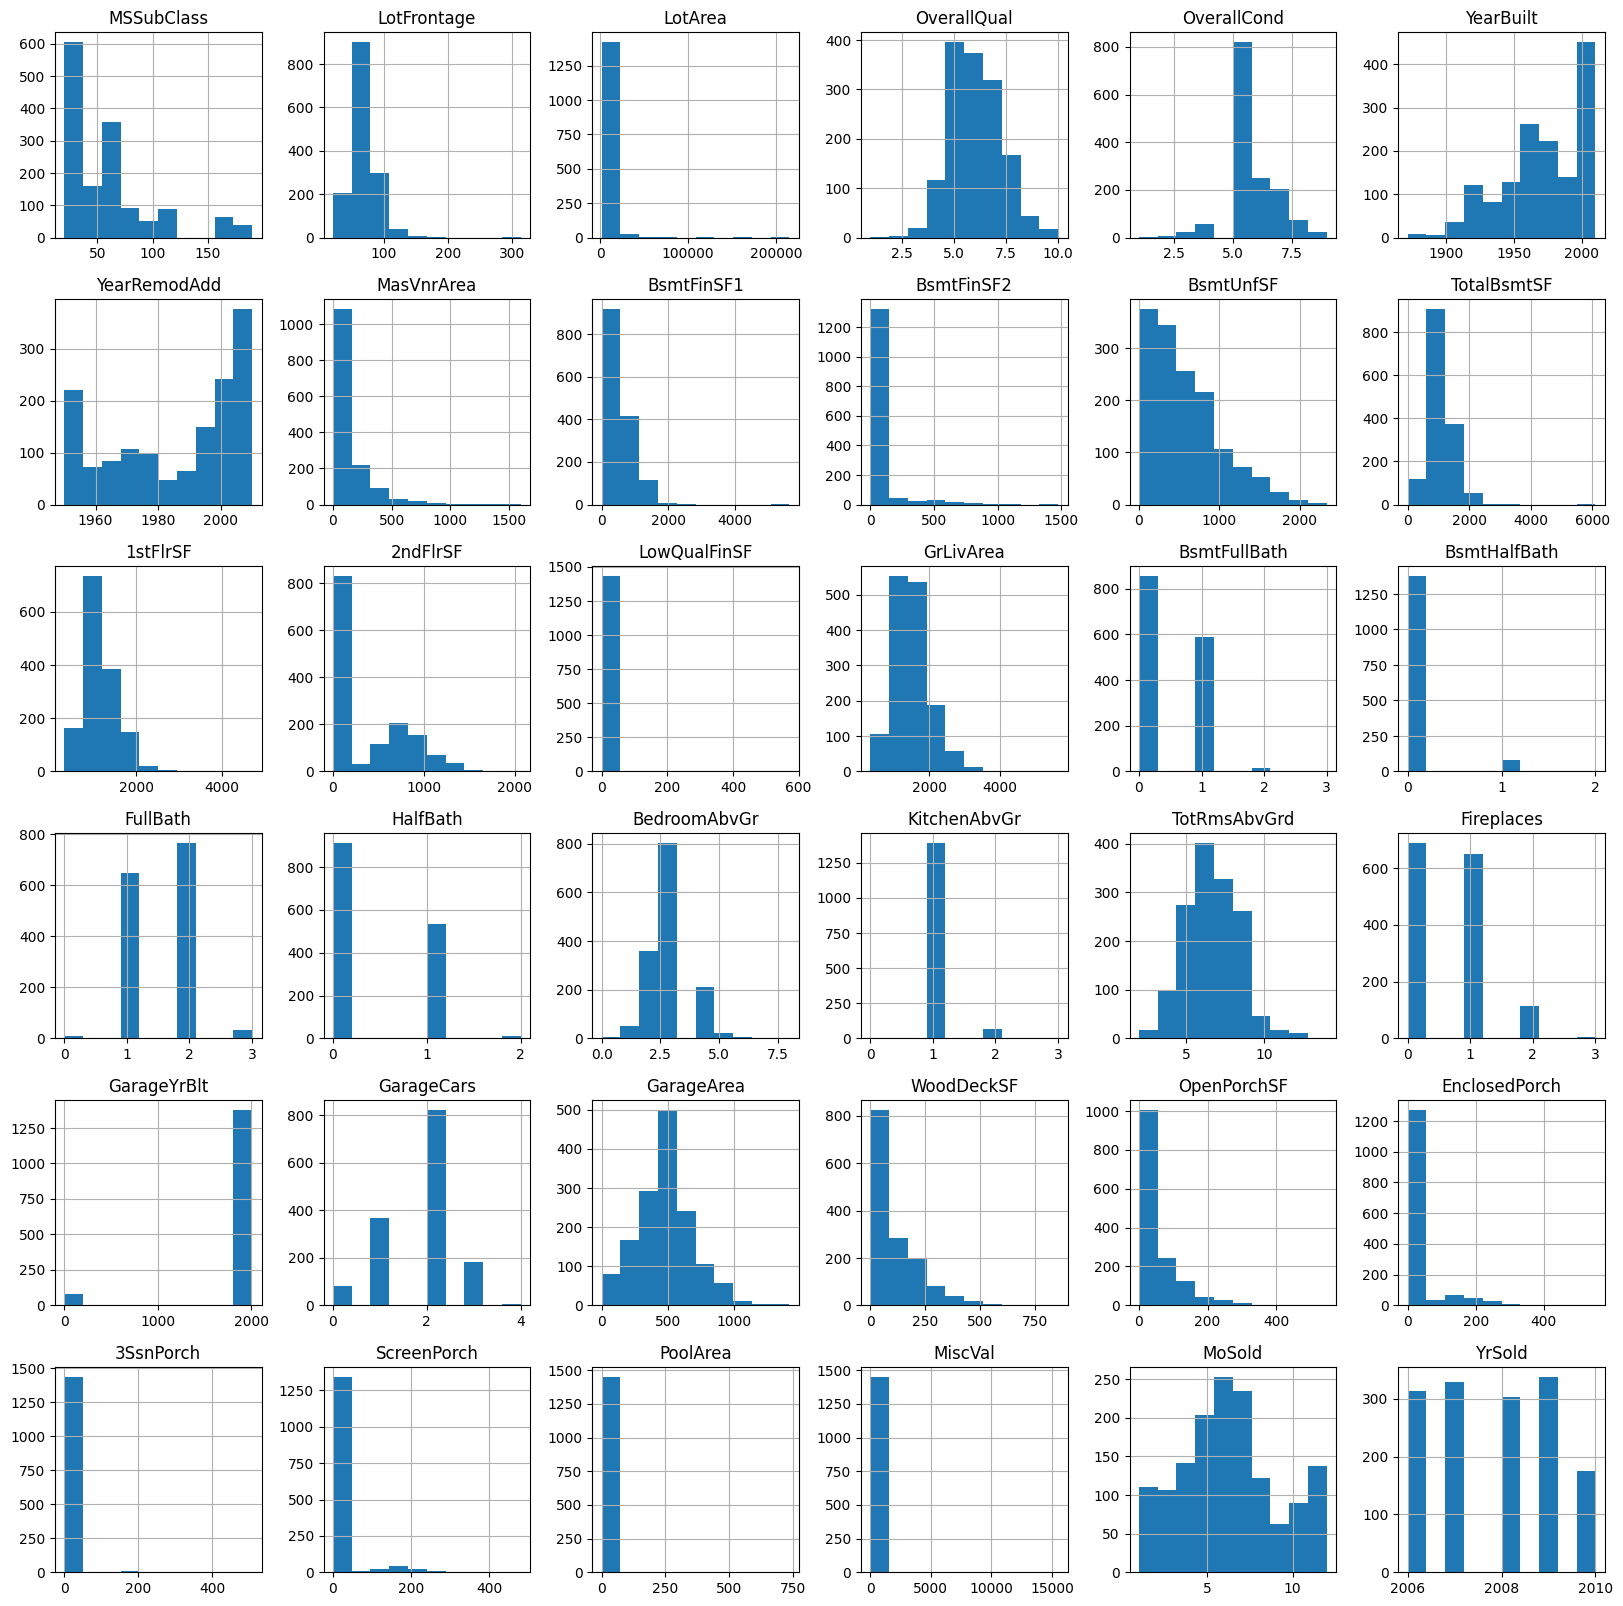

In [19]:
df_num.hist(figsize=(20,20))

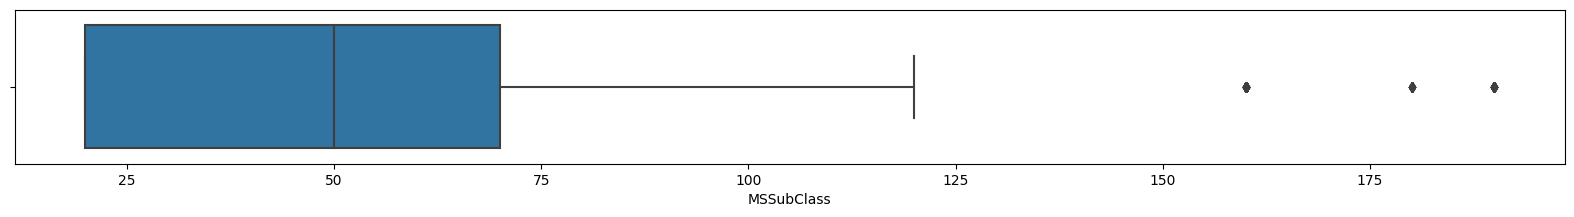

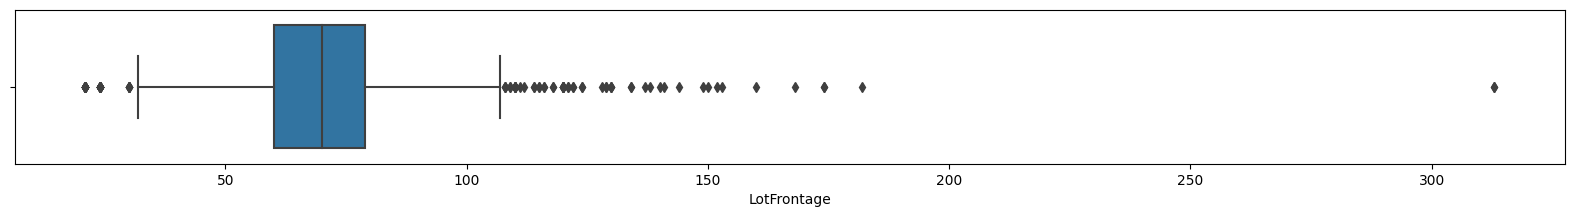

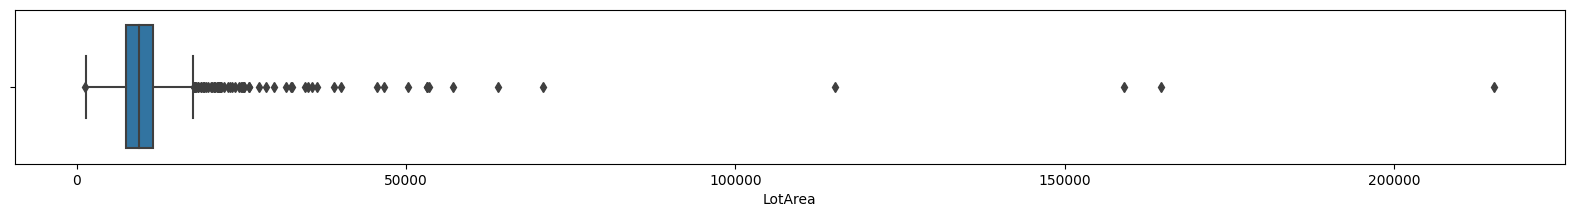

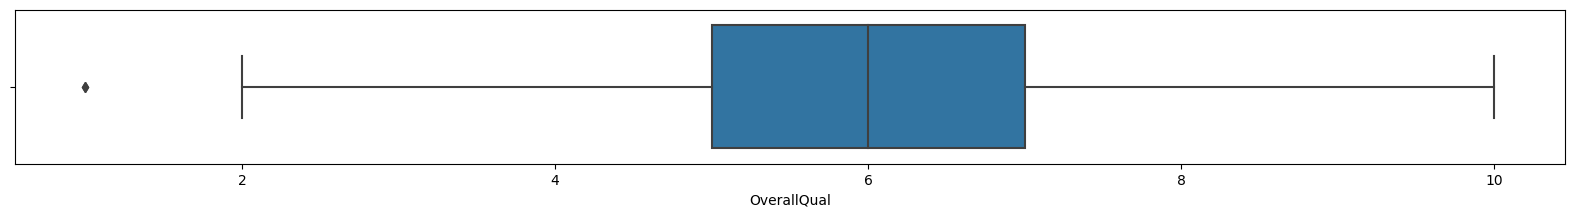

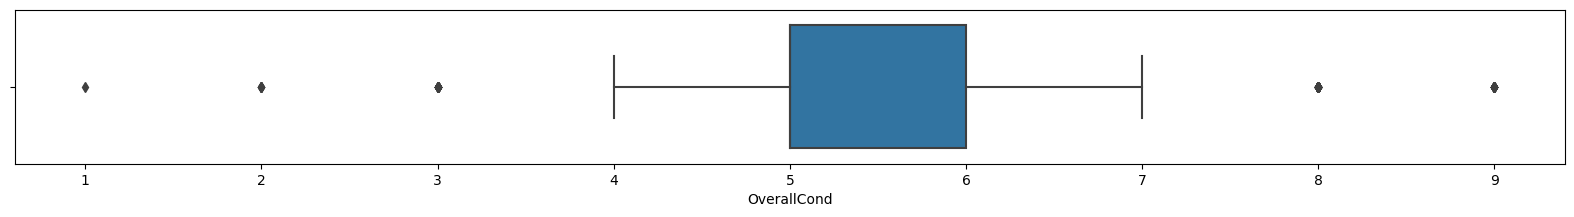

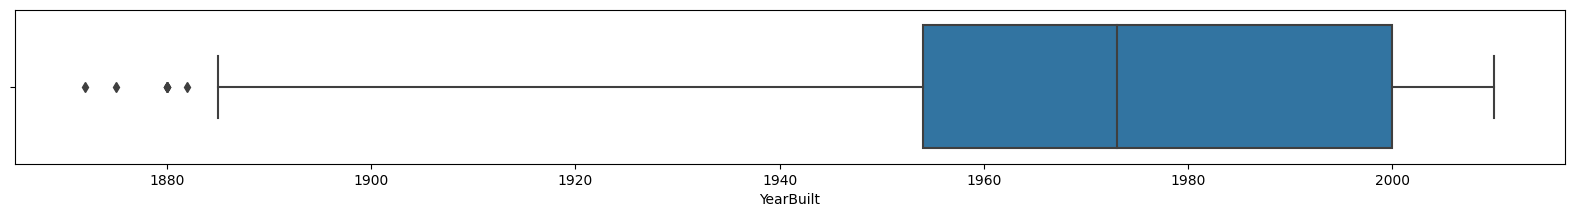

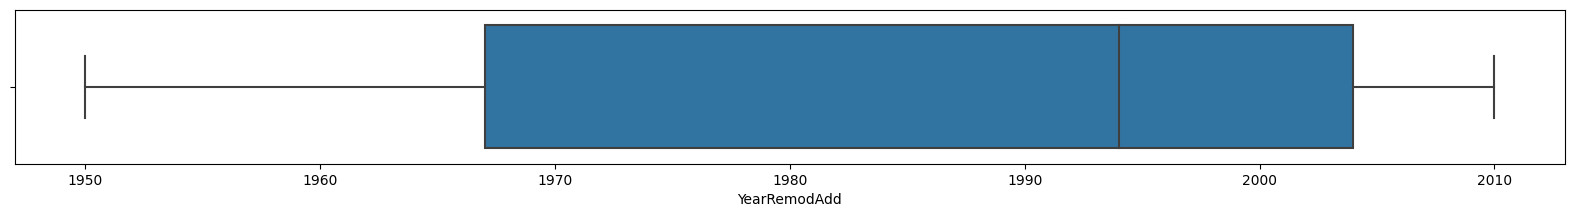

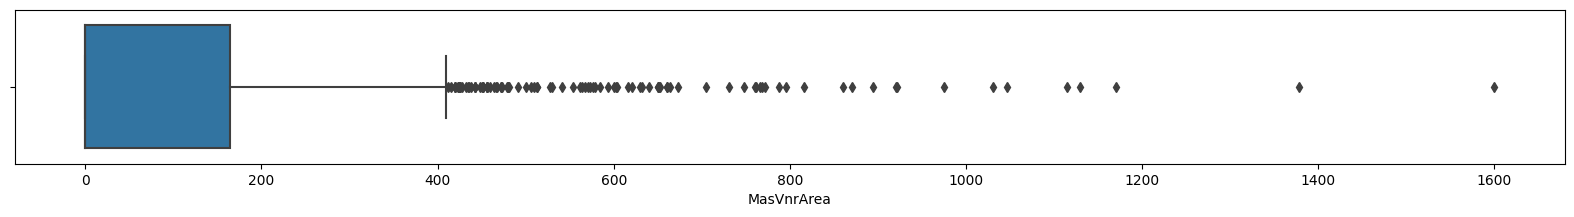

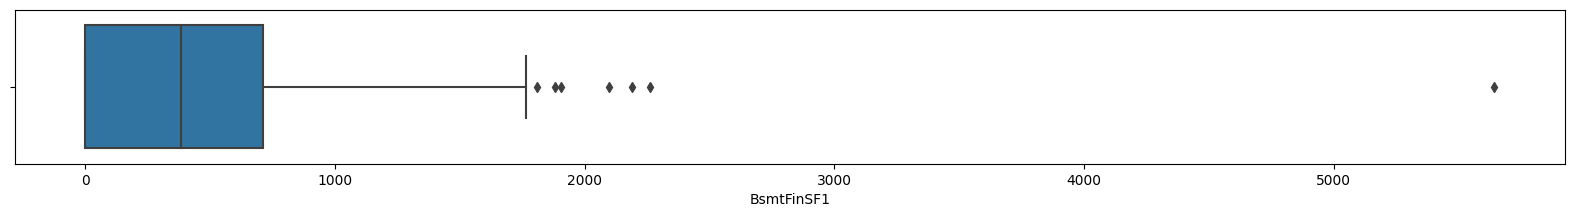

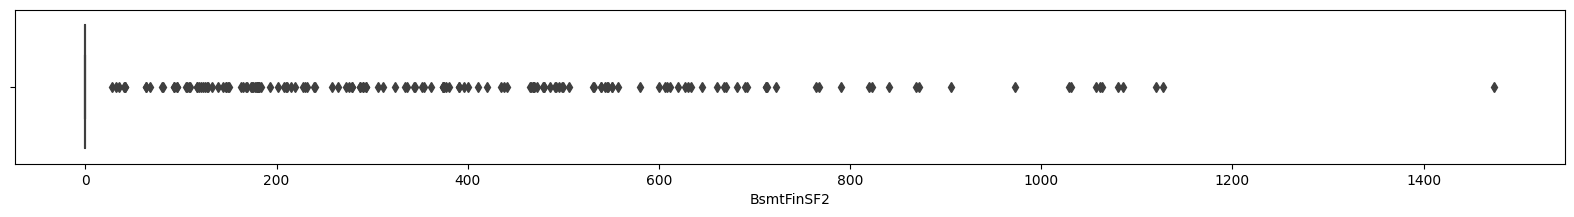

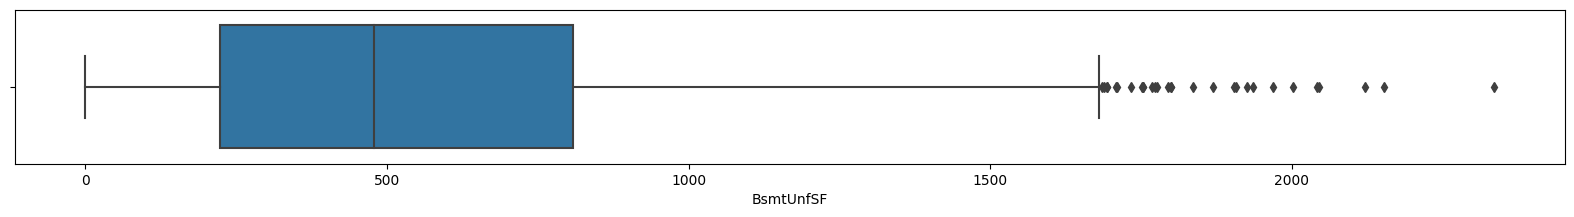

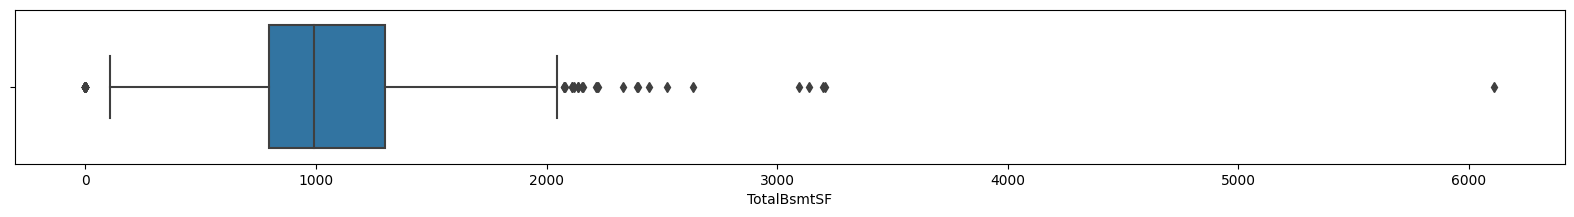

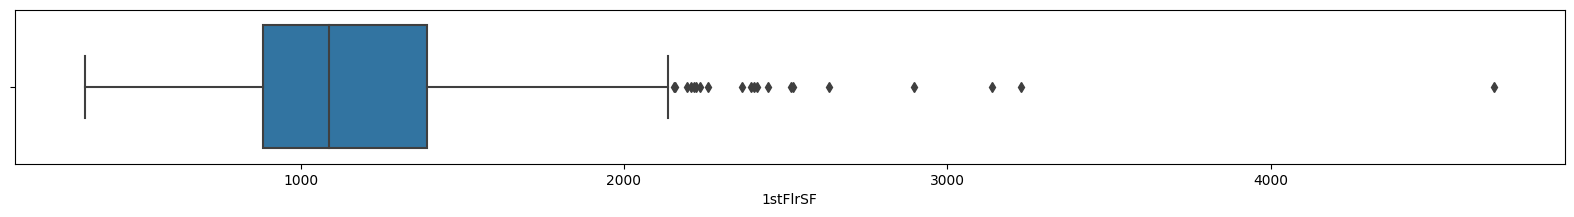

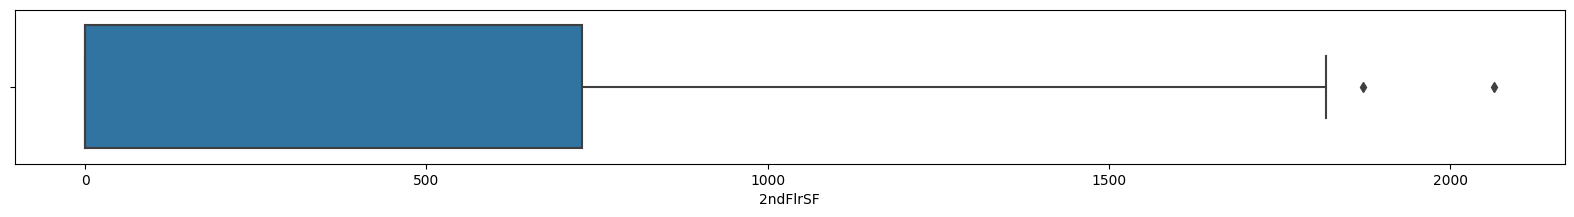

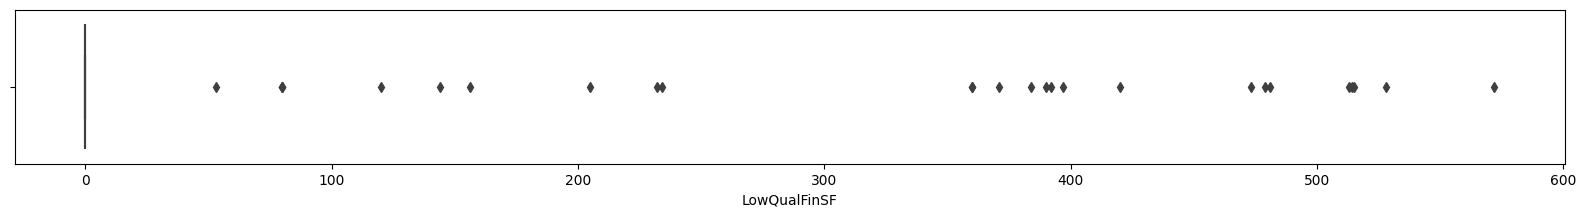

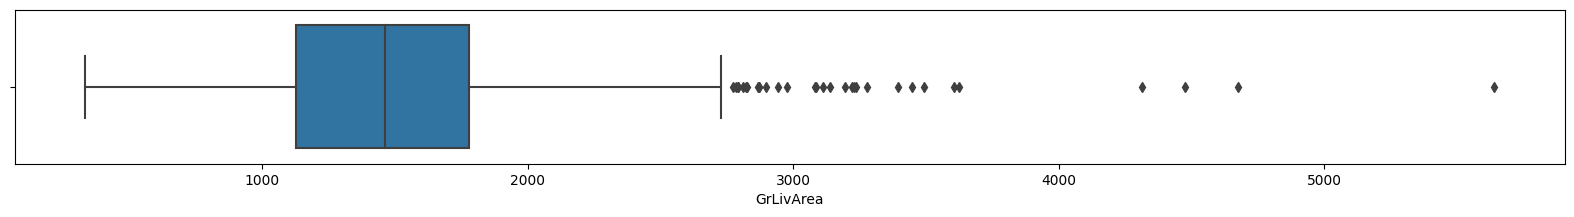

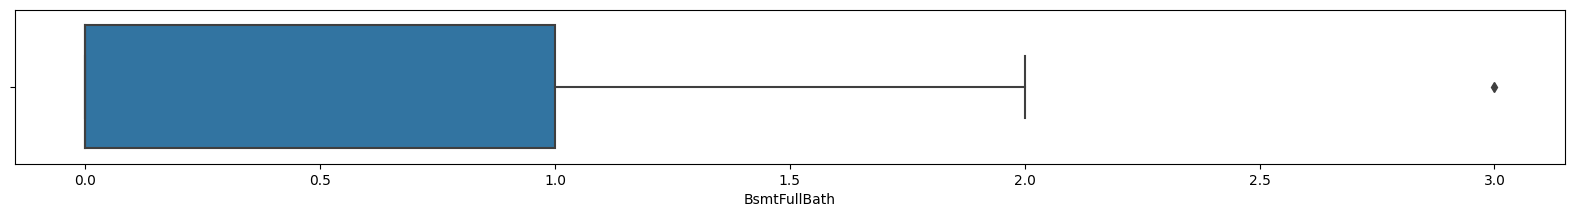

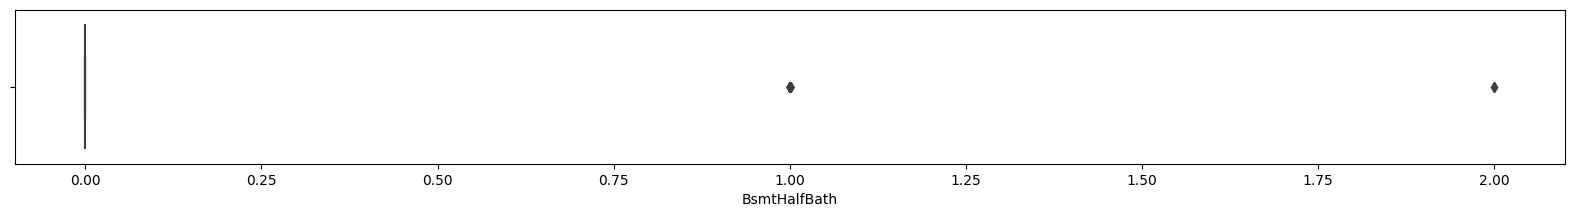

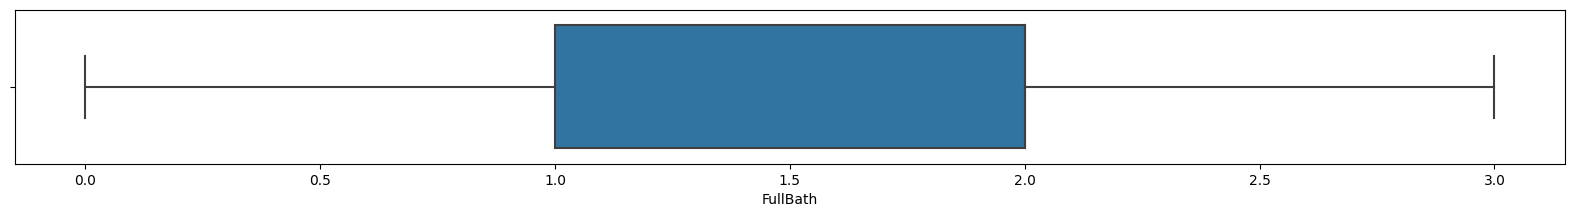

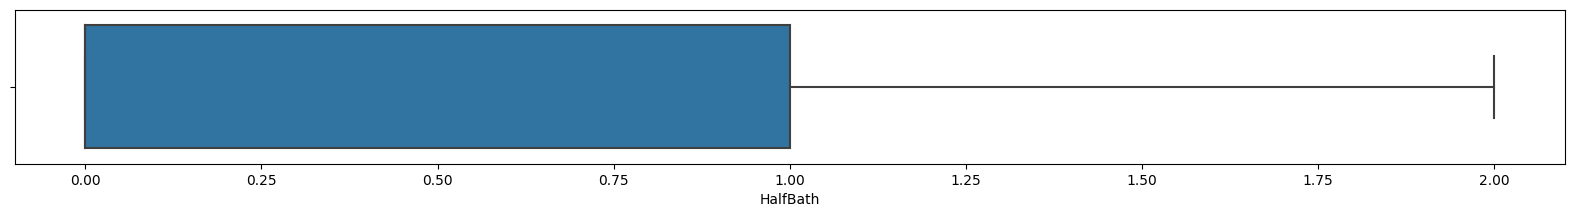

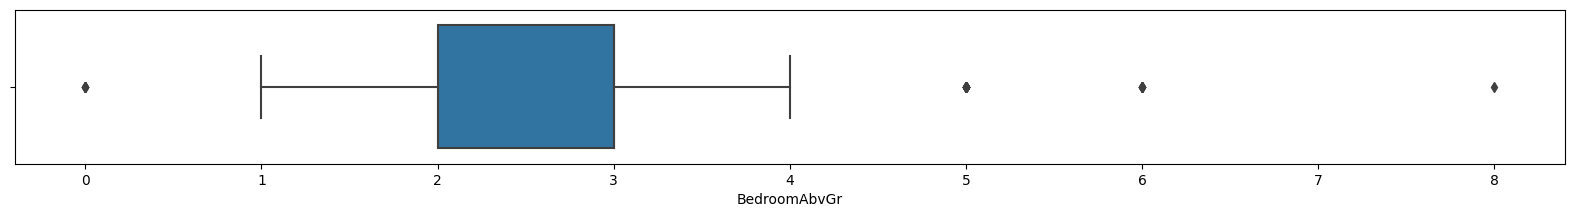

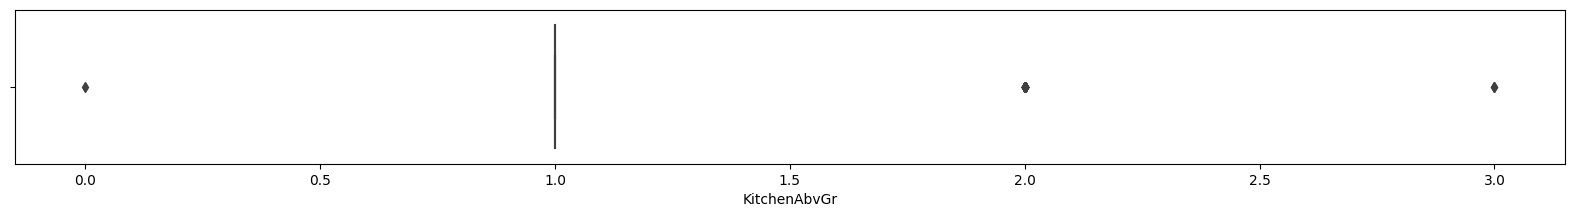

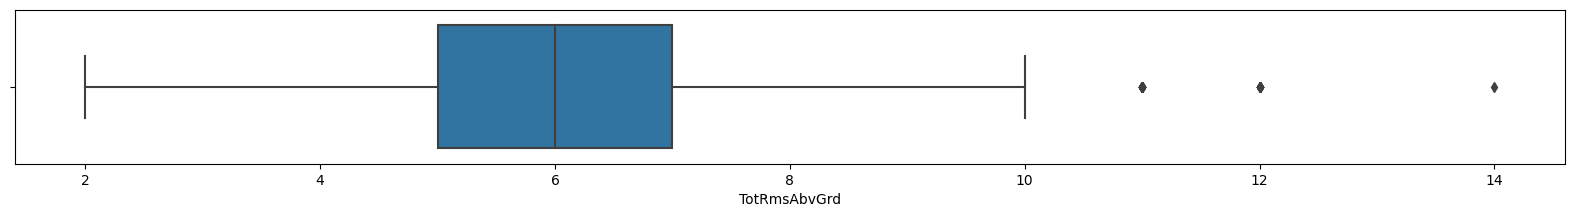

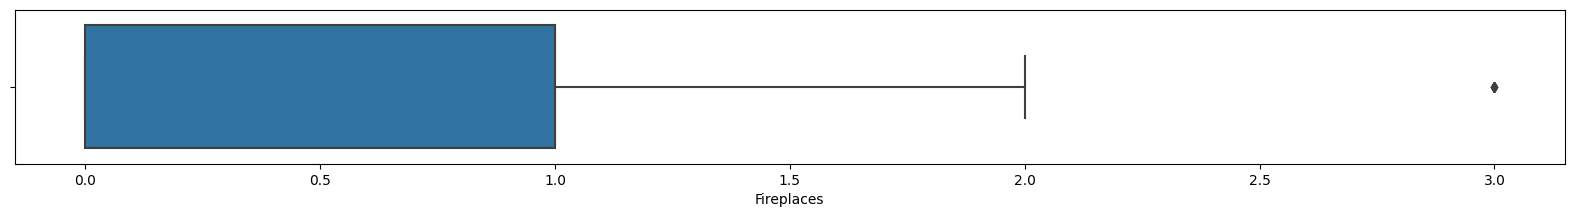

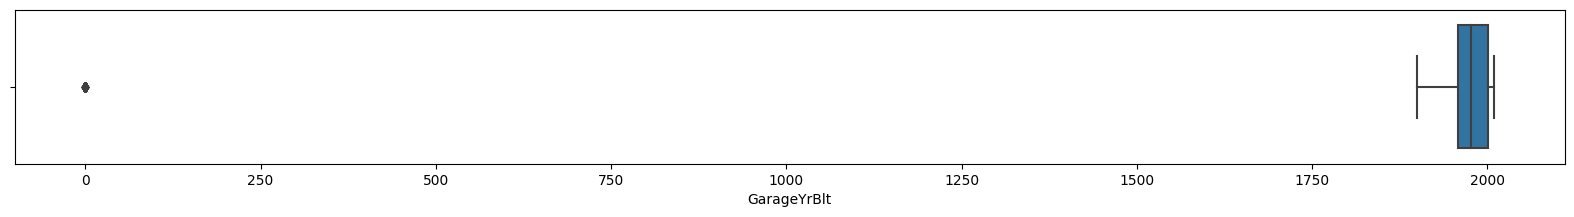

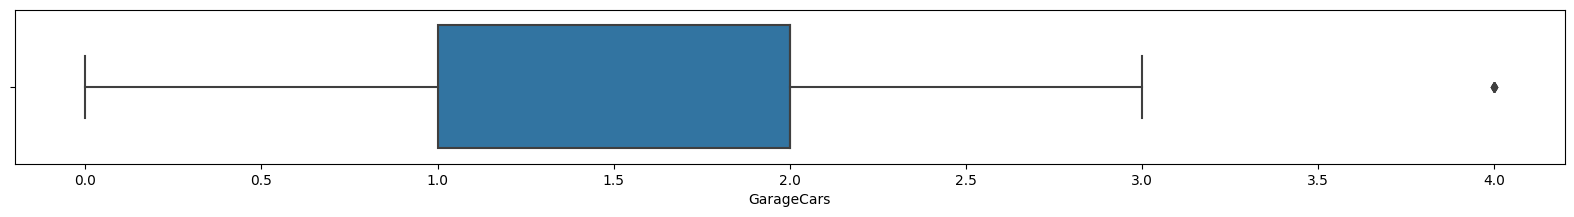

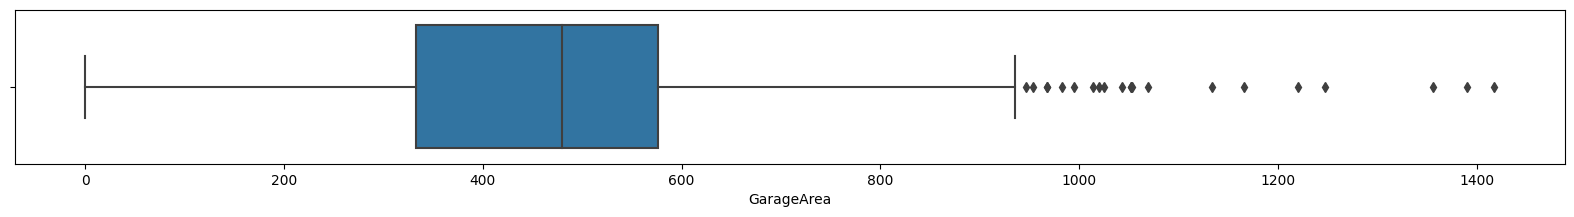

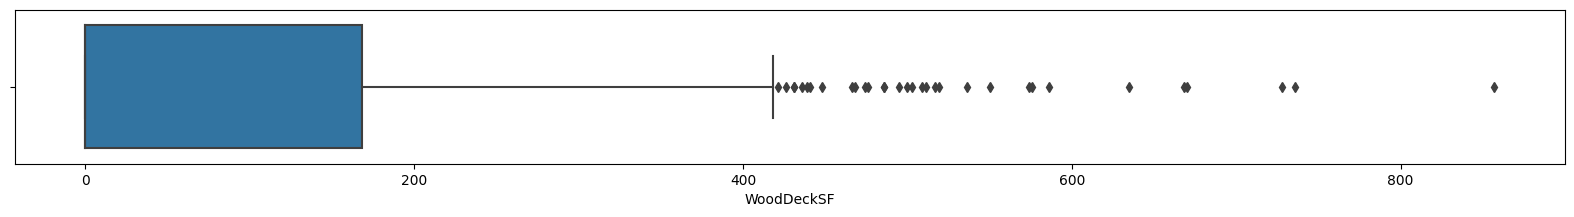

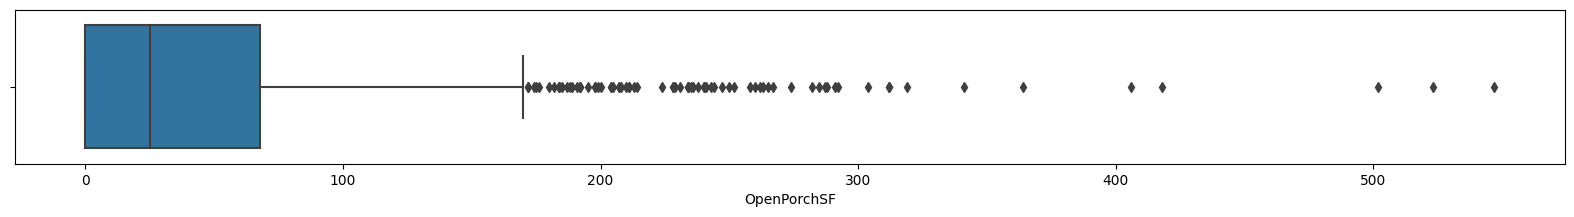

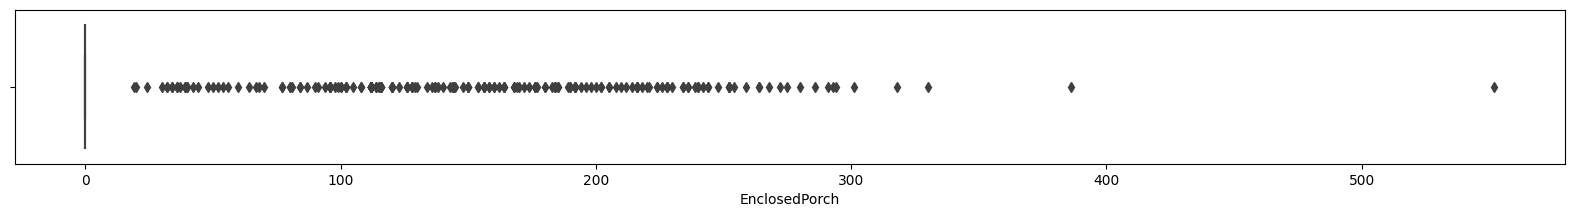

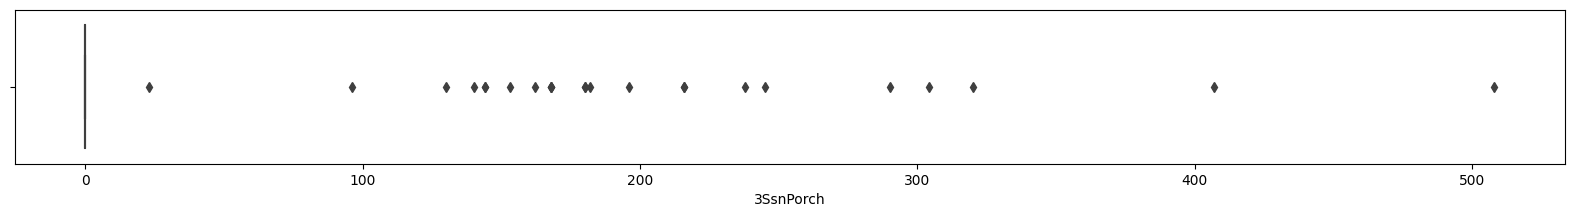

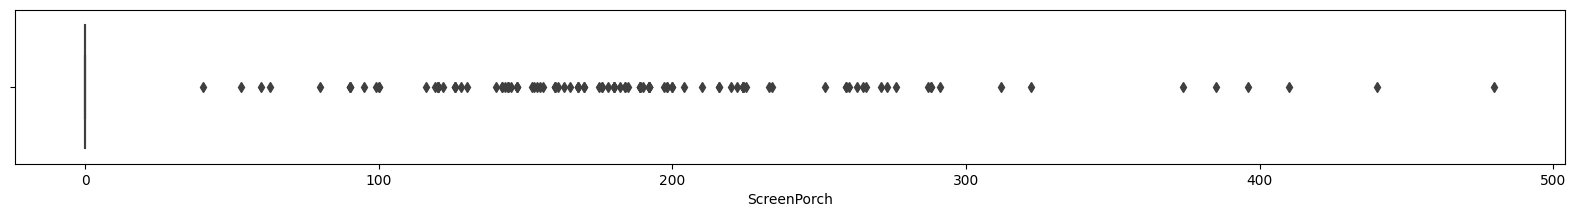

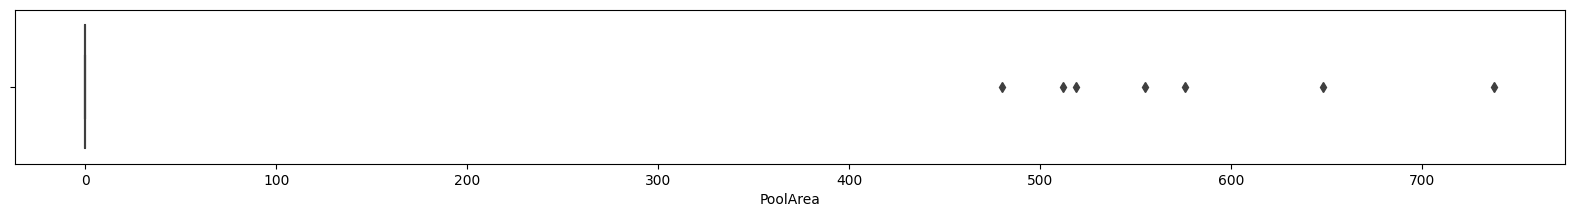

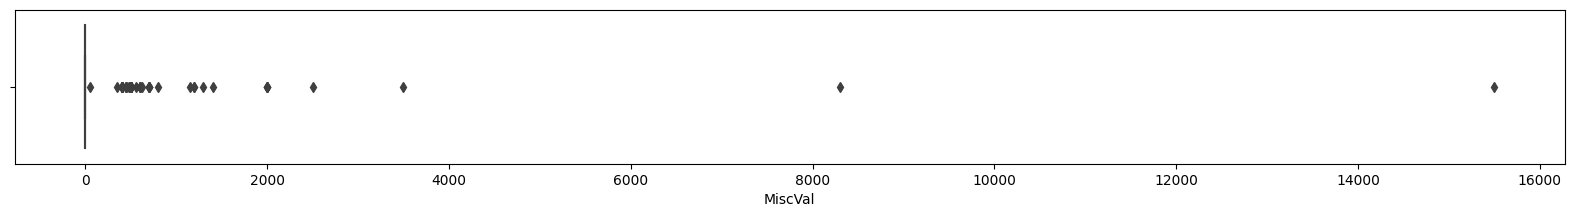

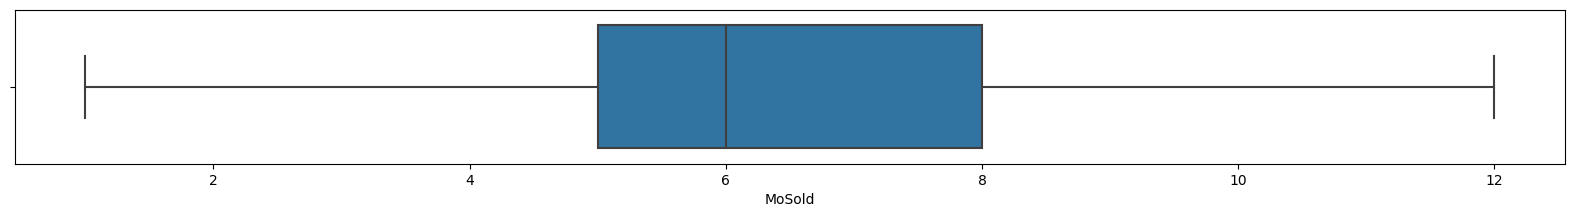

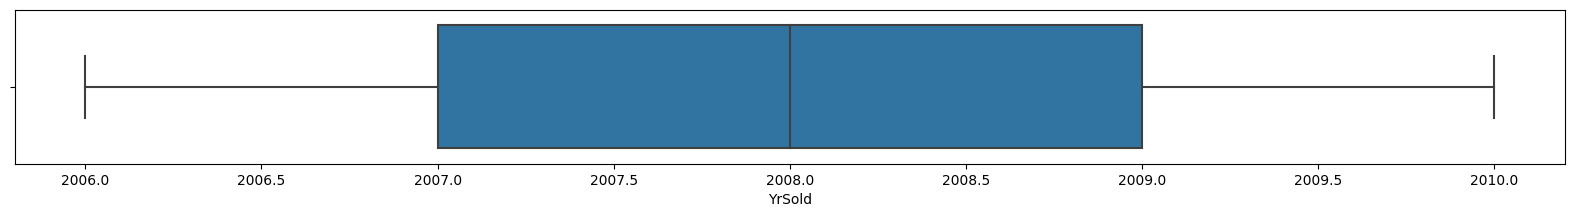

In [20]:
for col in df_num.columns:
    fig, ax = plt.subplots(figsize=(20, 2))
    sns.boxplot(x=df_num[col], ax=ax)
    plt.show()

In [21]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
df_num_scale = pd.DataFrame(ss.fit_transform(df_num), index=df_num.index, columns=df_num.columns)
df_num_scale.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,0.073732,-0.229183,-0.207125,0.650852,-0.517424,1.051899,0.879449,0.513594,0.574748,-0.28876,...,0.350660,-0.751887,0.215983,-0.359464,-0.11638,-0.270308,-0.068715,-0.087718,-1.599030,0.138826
2,-0.871979,0.451896,-0.091909,-0.072372,2.178727,0.157540,-0.428864,-0.571009,1.171304,-0.28876,...,-0.060947,1.625670,-0.704845,-0.359464,-0.11638,-0.270308,-0.068715,-0.087718,-0.489318,-0.614137
3,0.073732,-0.092967,0.073401,0.650852,-0.517424,0.985650,0.830993,0.325449,0.092239,-0.28876,...,0.631301,-0.751887,-0.070832,-0.359464,-0.11638,-0.270308,-0.068715,-0.087718,0.990298,0.138826
4,0.310159,-0.456209,-0.096918,0.650852,-0.517424,-1.863050,-0.719600,-0.571009,-0.499931,-0.28876,...,0.790331,-0.751887,-0.176501,4.091057,-0.11638,-0.270308,-0.068715,-0.087718,-1.599030,-1.367100
5,0.073732,0.633517,0.374967,1.374077,-0.517424,0.952526,0.734081,1.365783,0.462893,-0.28876,...,1.697737,0.779962,0.563180,-0.359464,-0.11638,-0.270308,-0.068715,-0.087718,2.100010,0.138826


#### Обработка категориальных данных

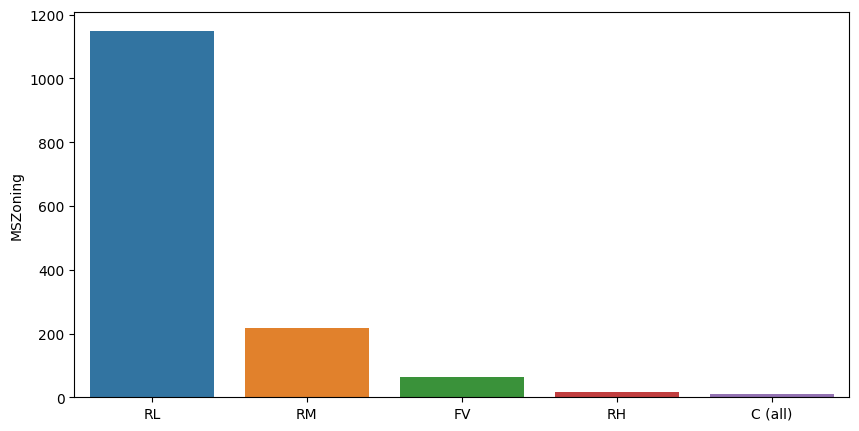

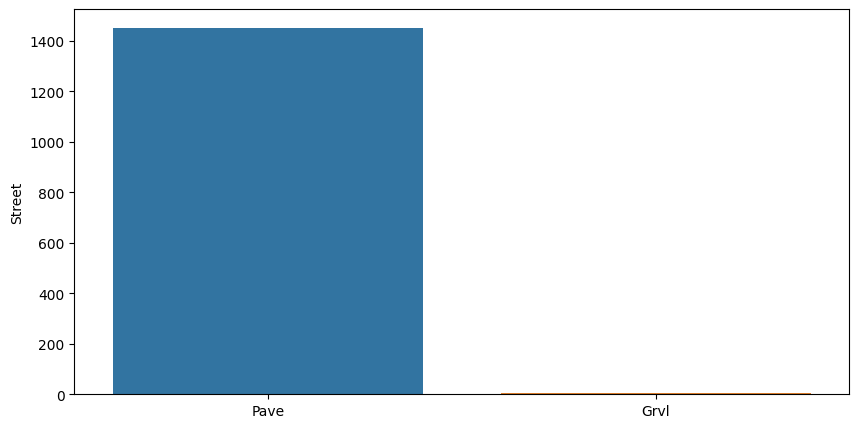

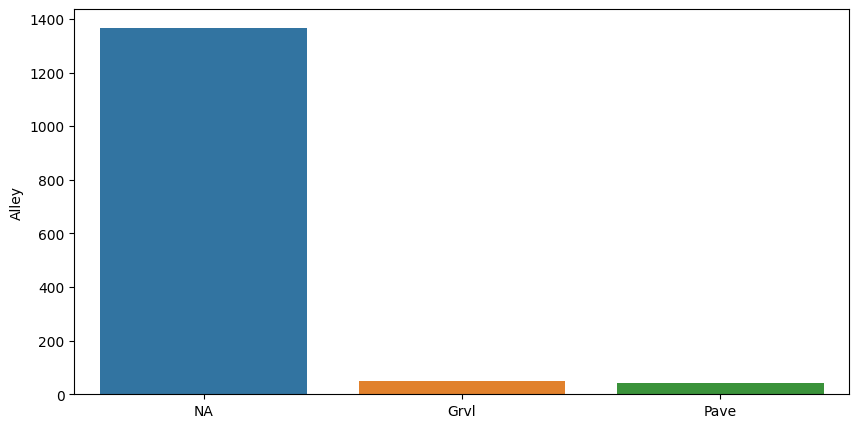

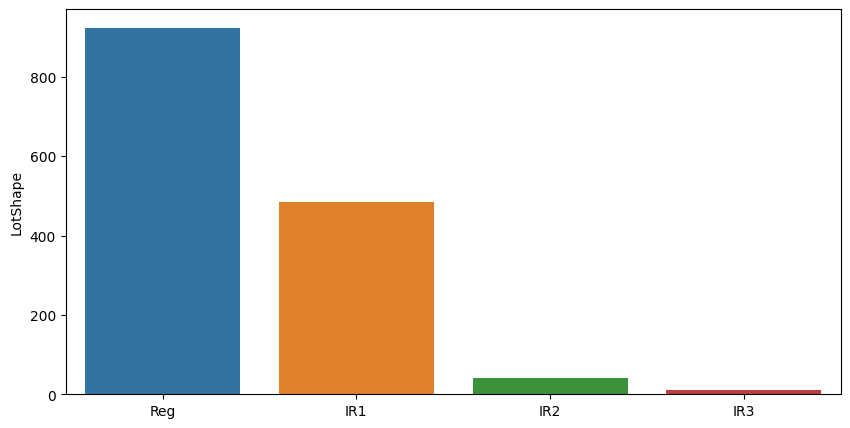

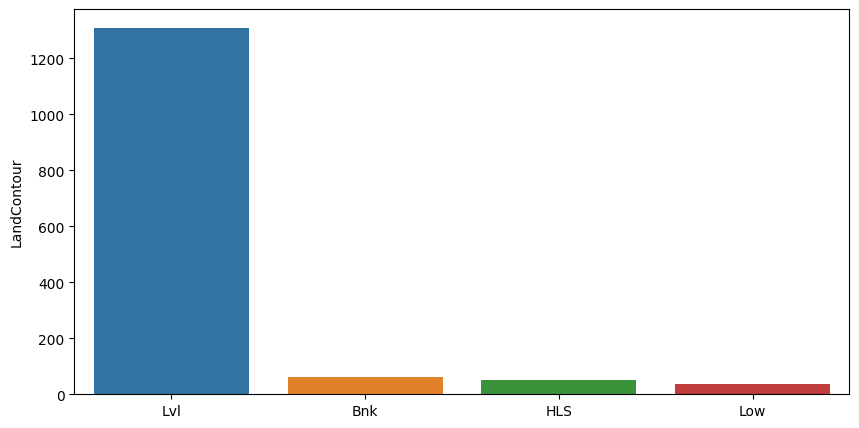

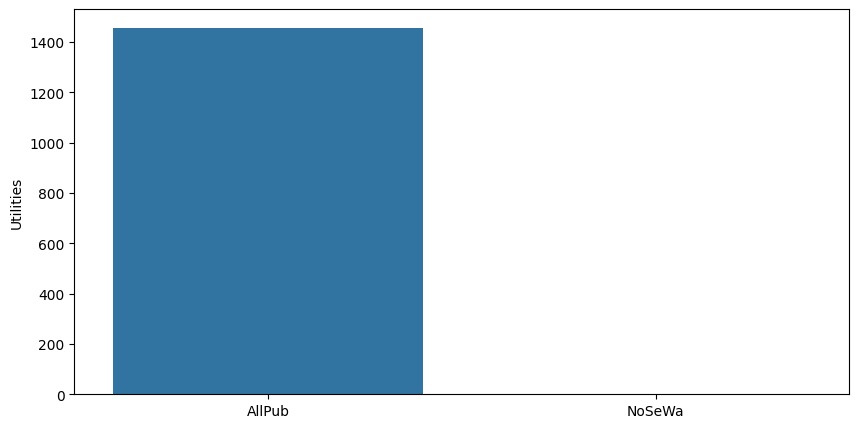

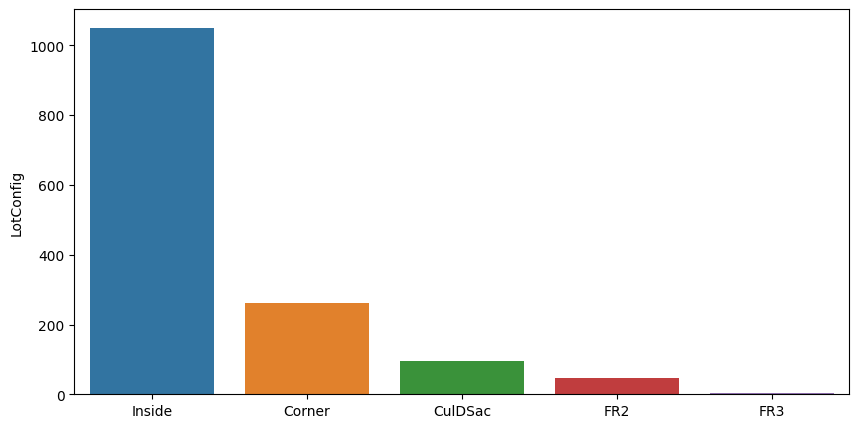

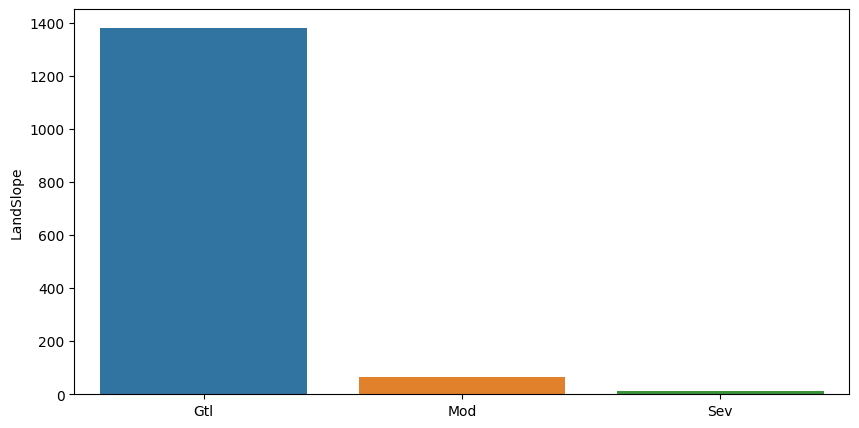

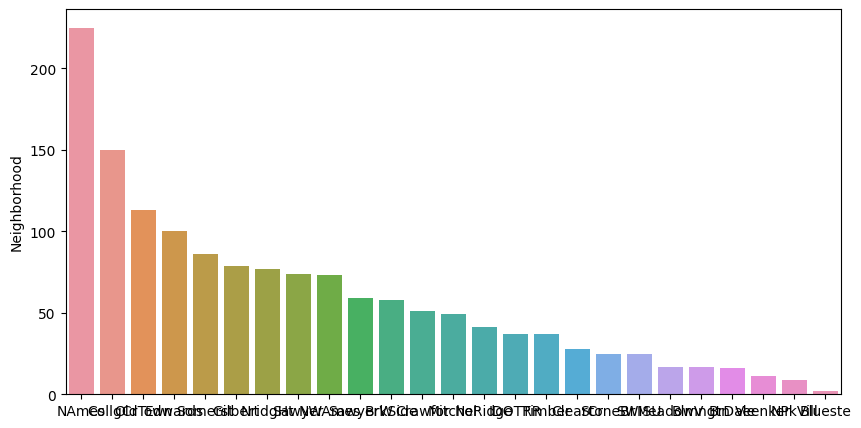

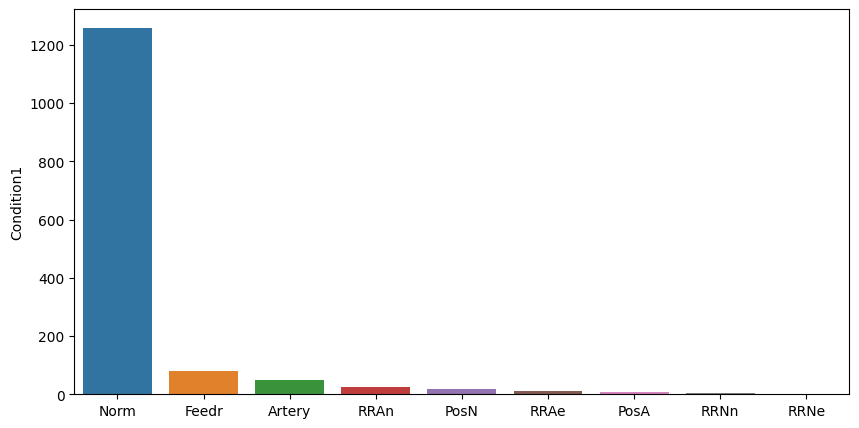

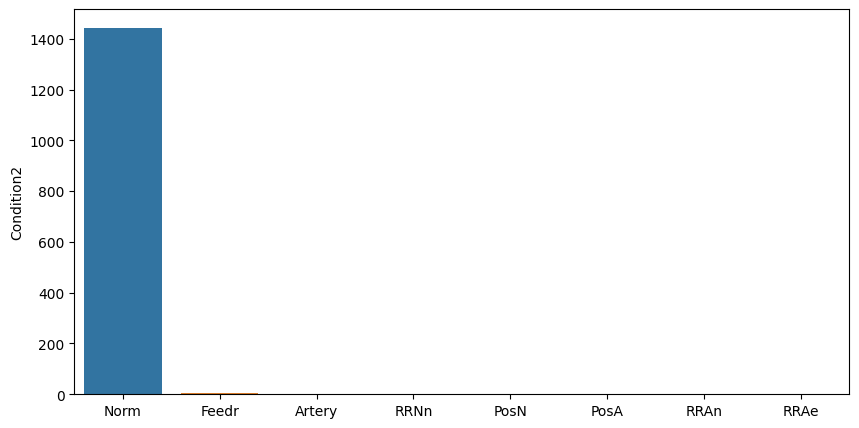

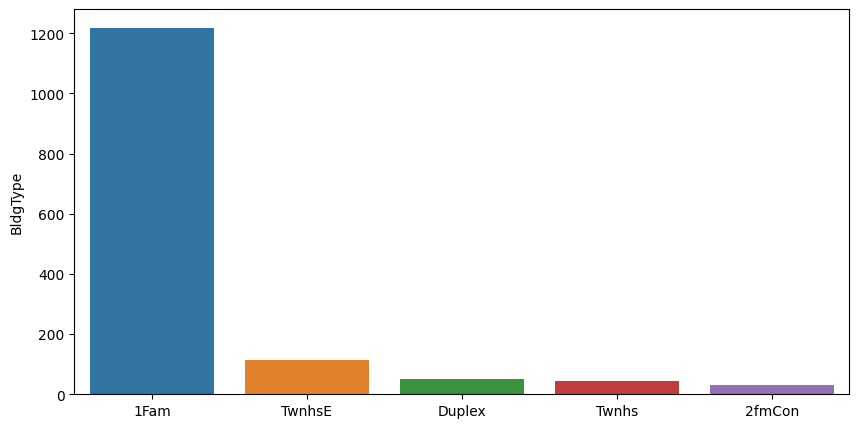

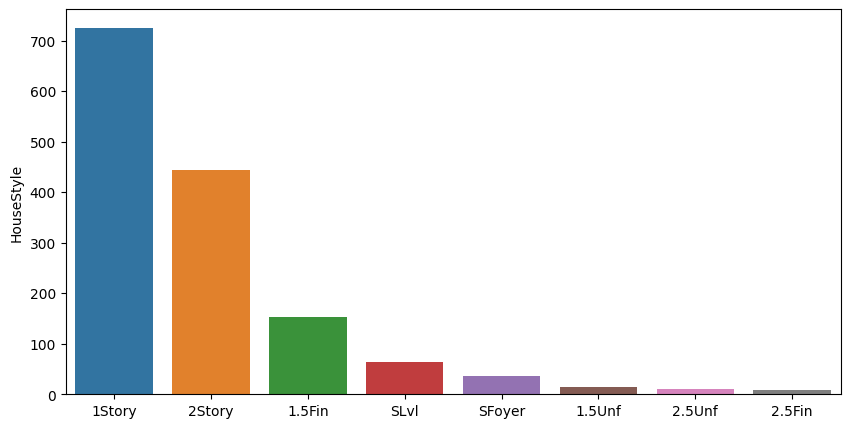

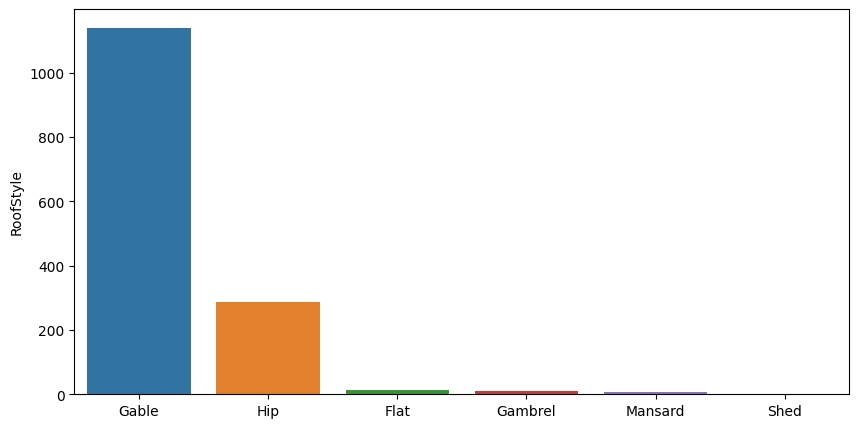

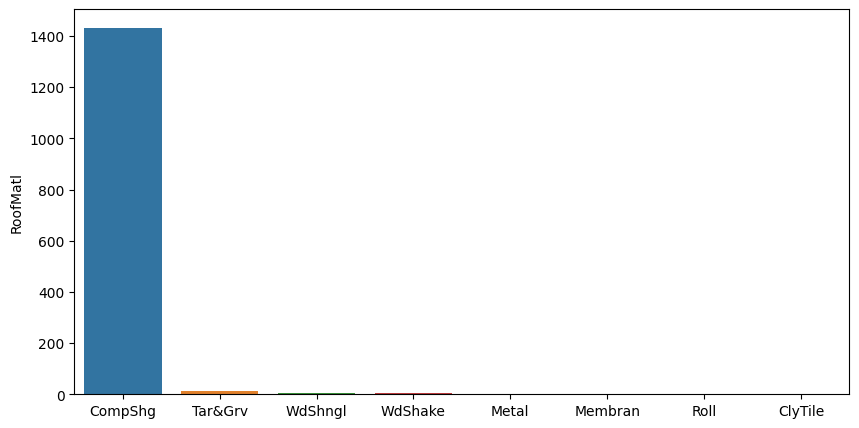

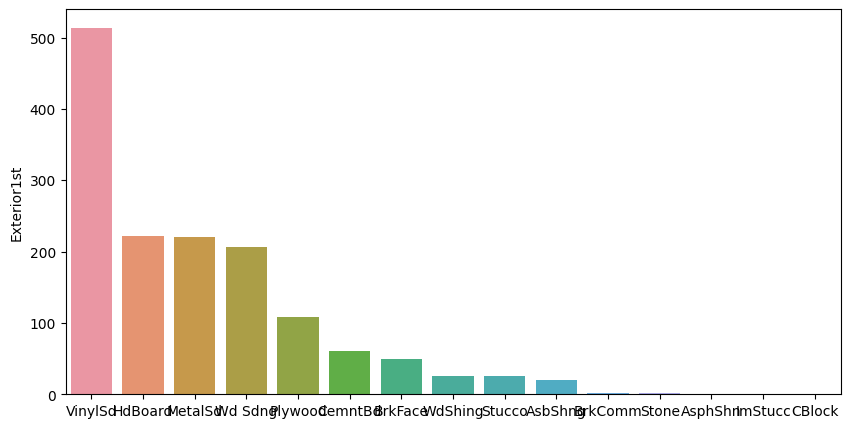

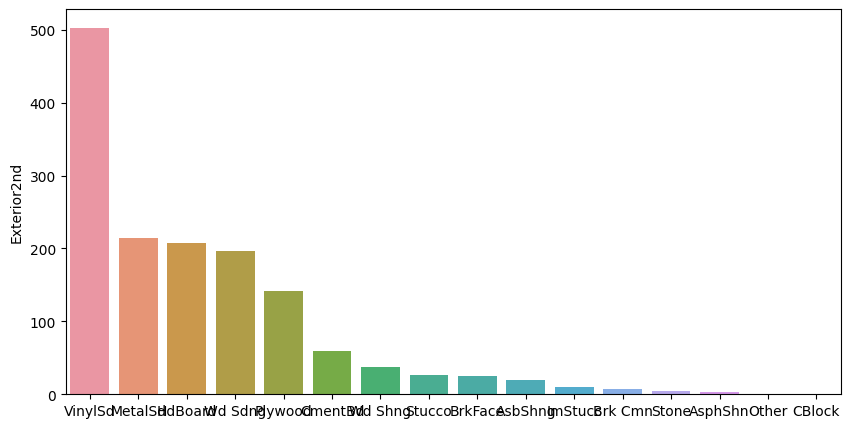

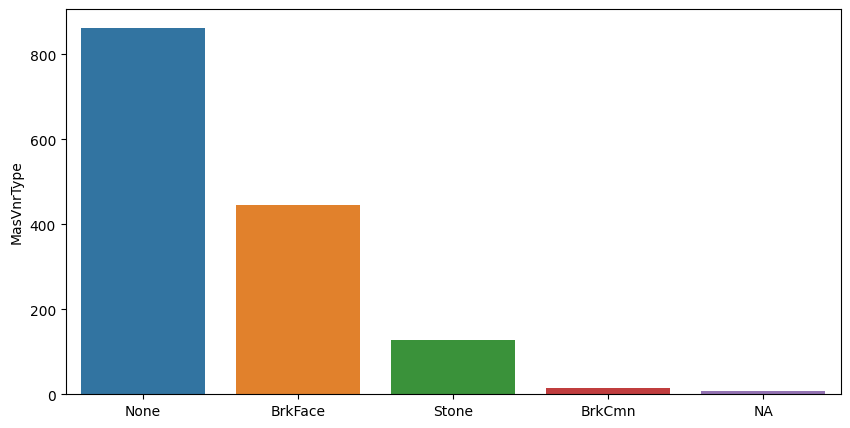

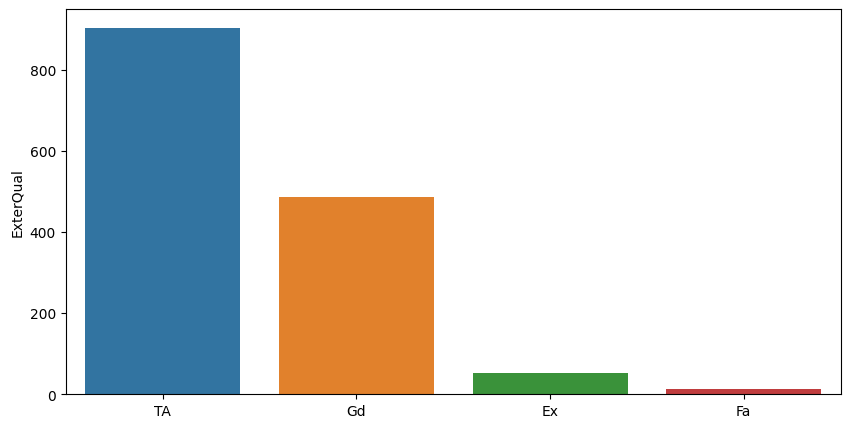

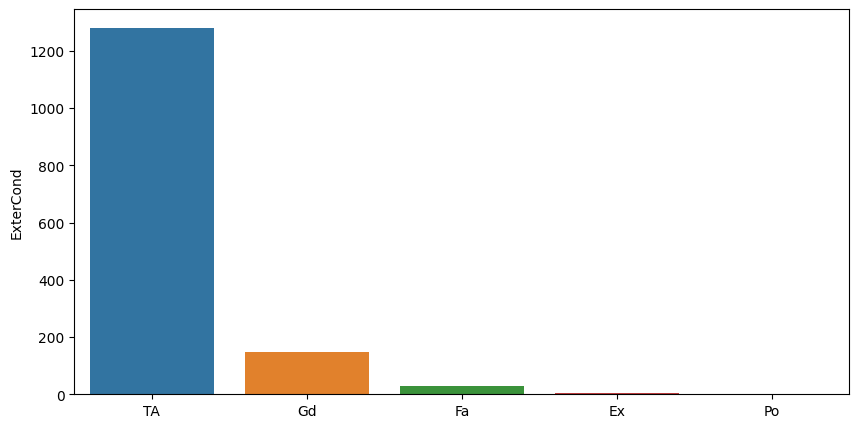

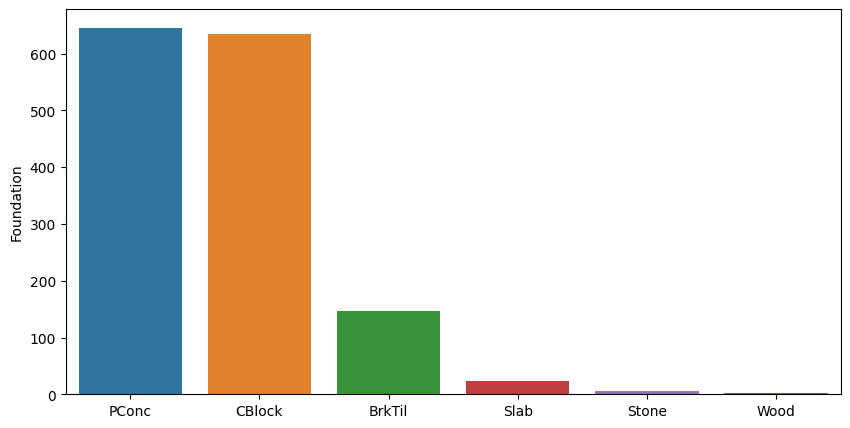

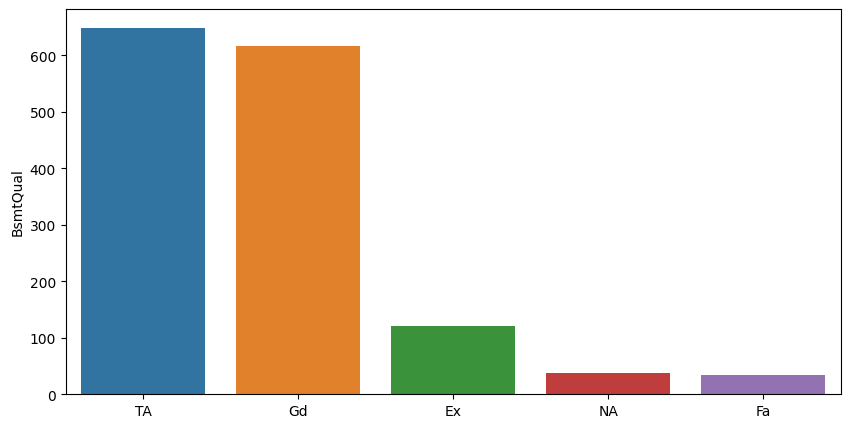

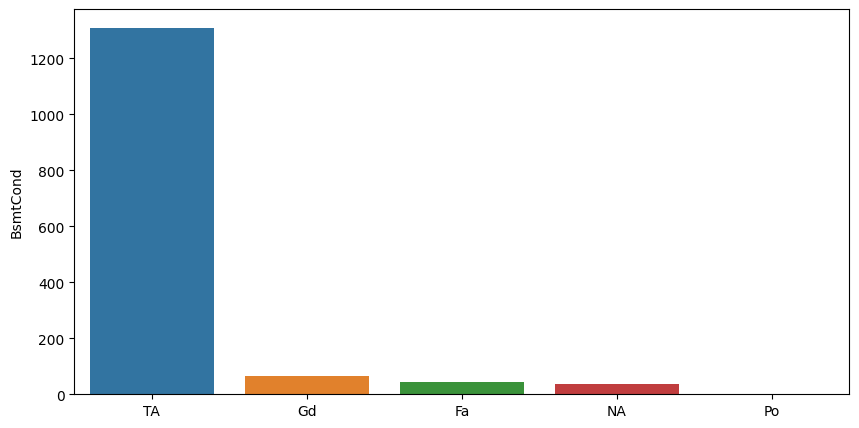

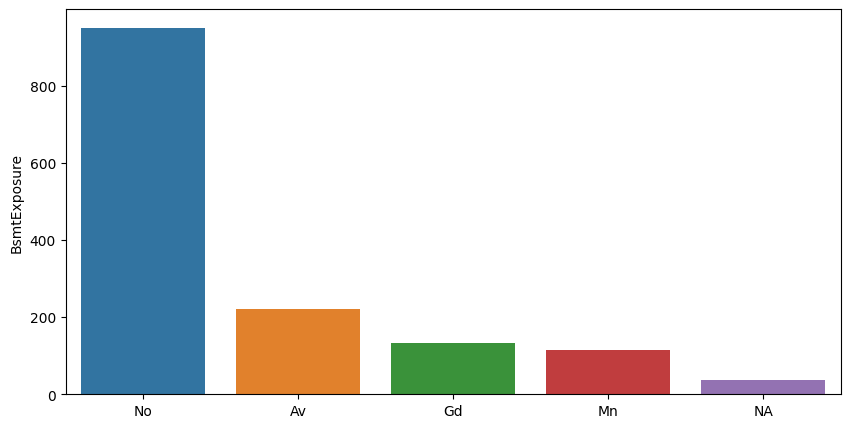

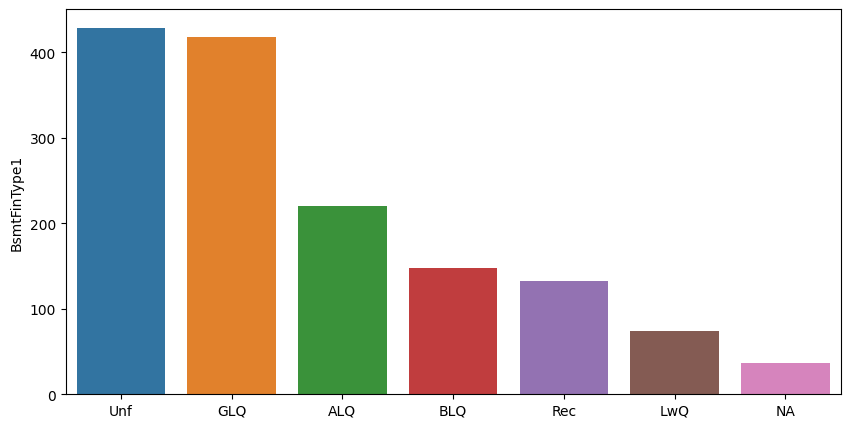

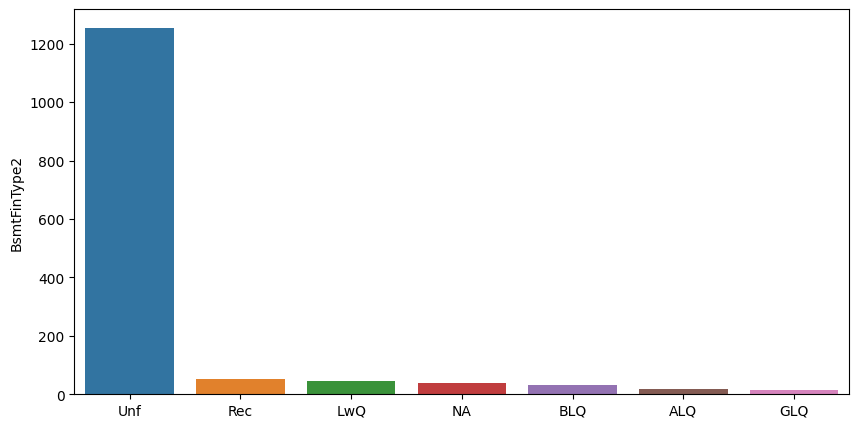

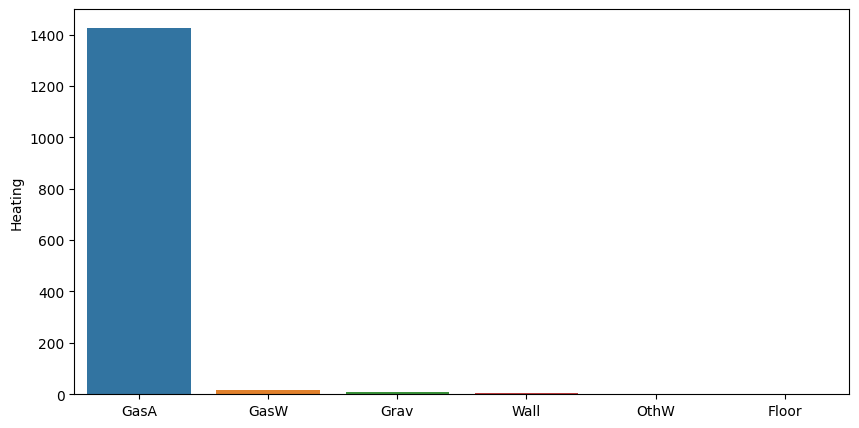

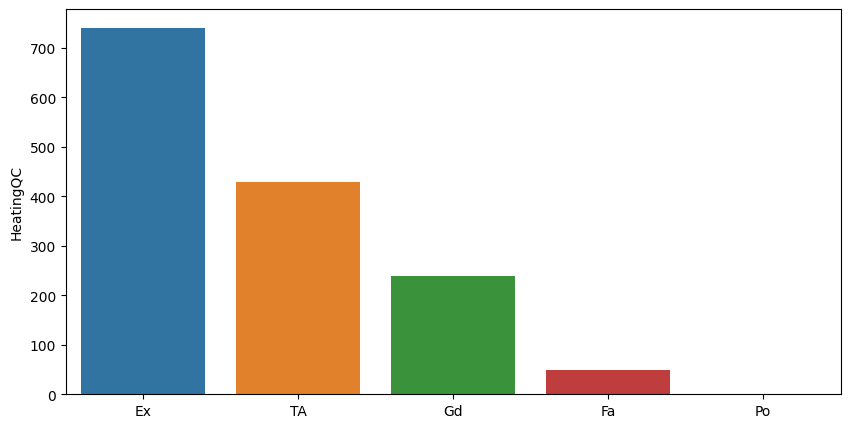

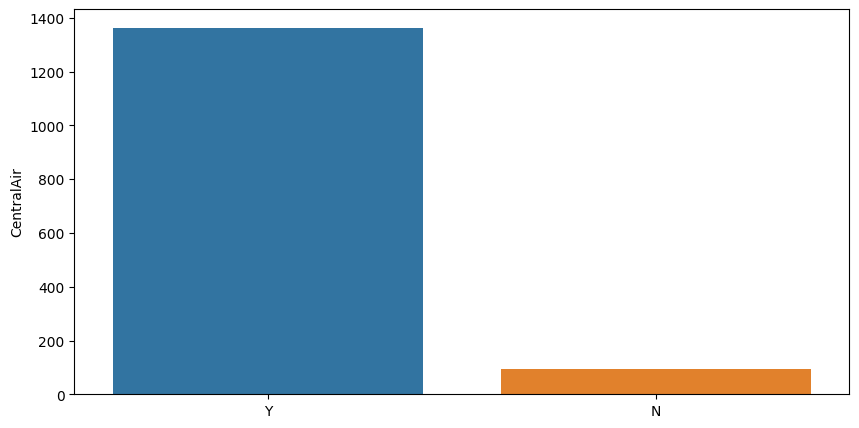

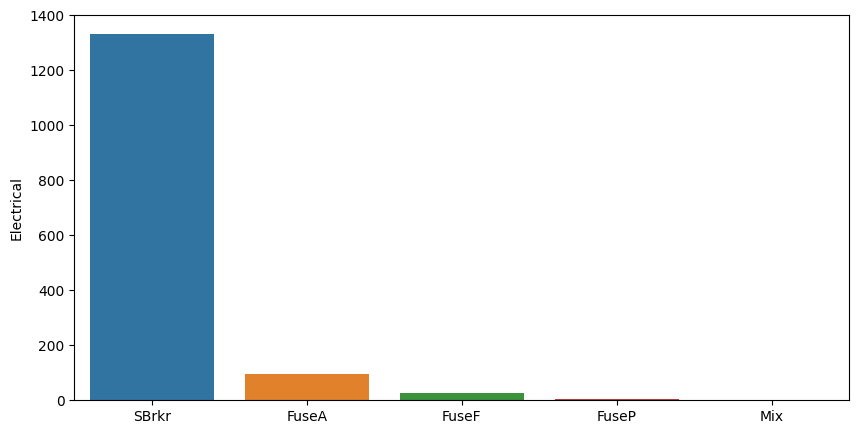

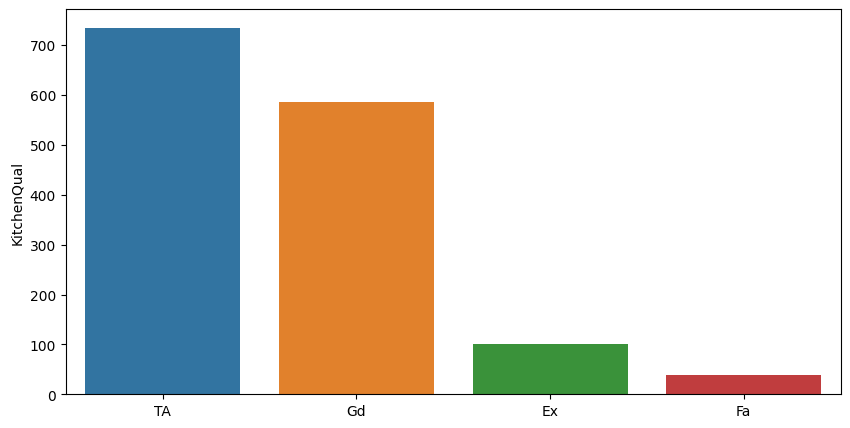

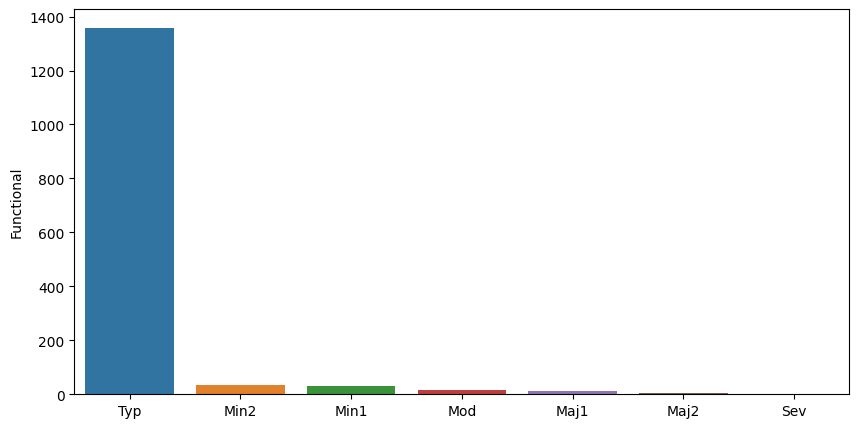

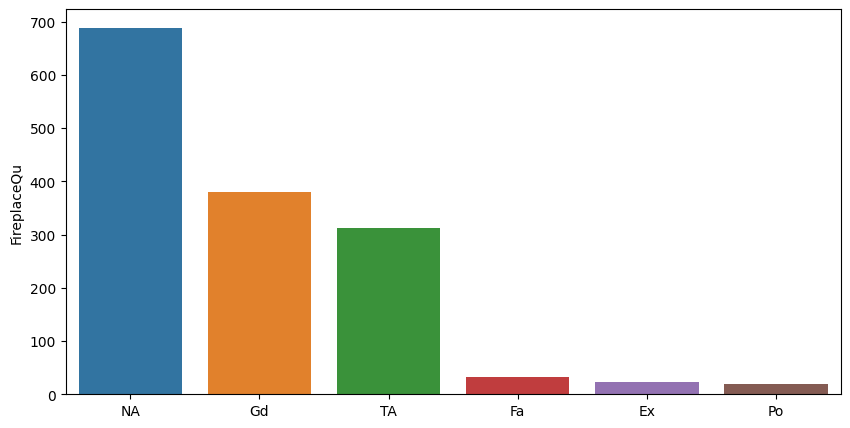

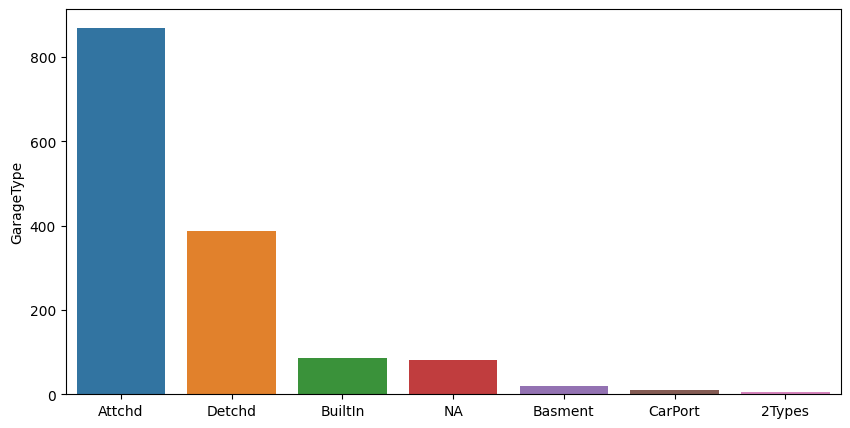

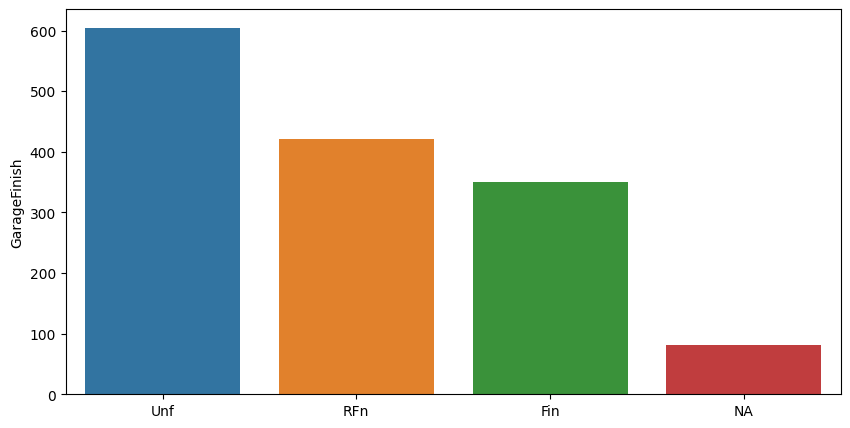

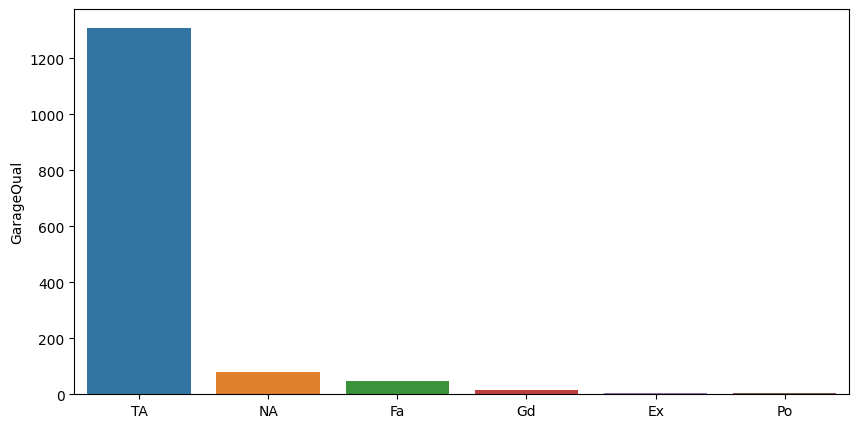

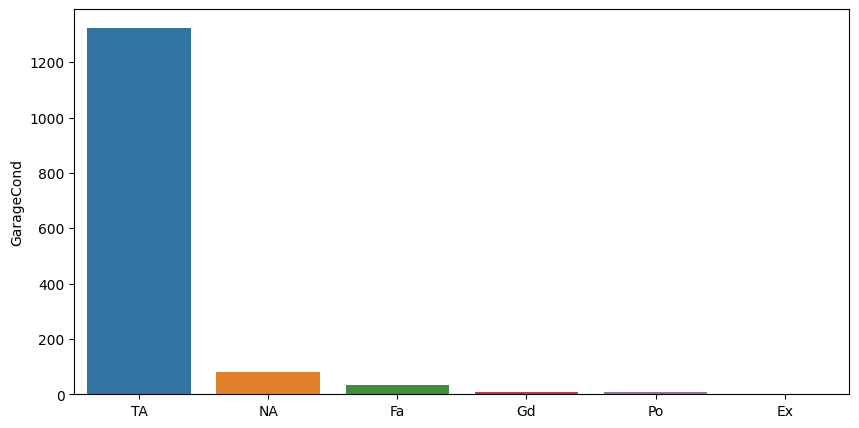

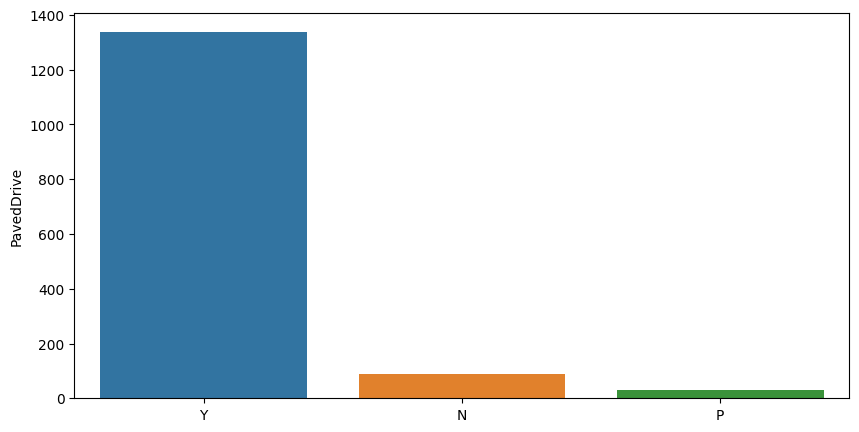

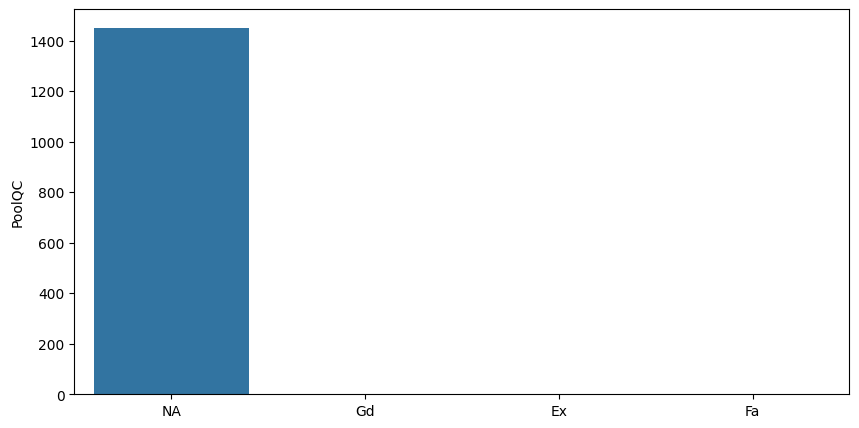

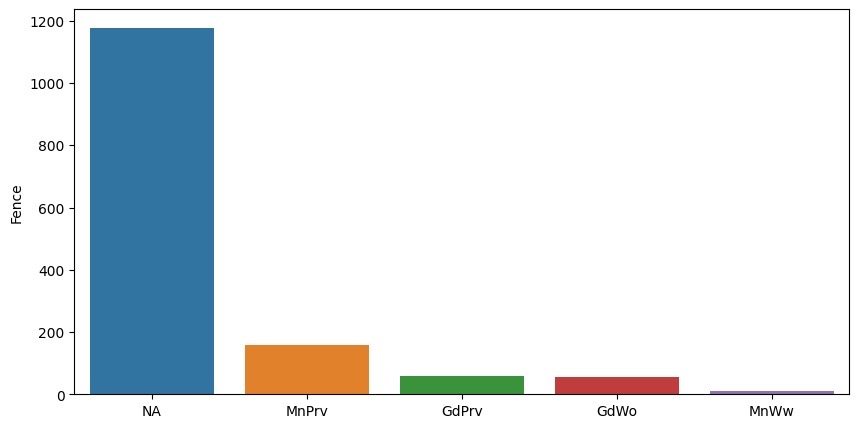

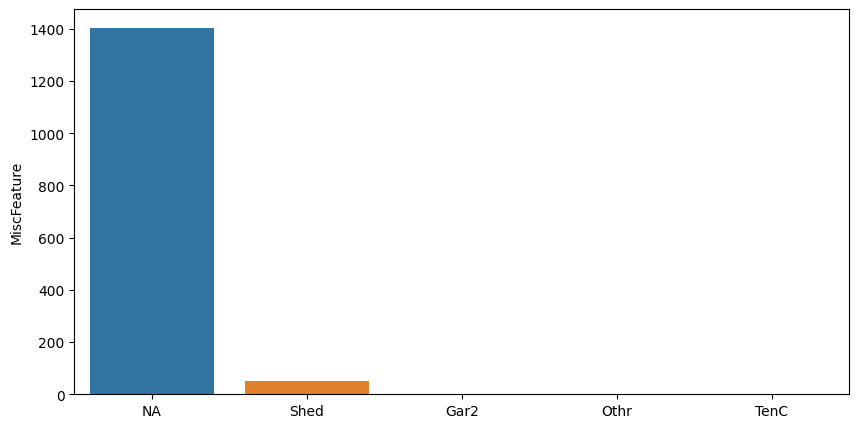

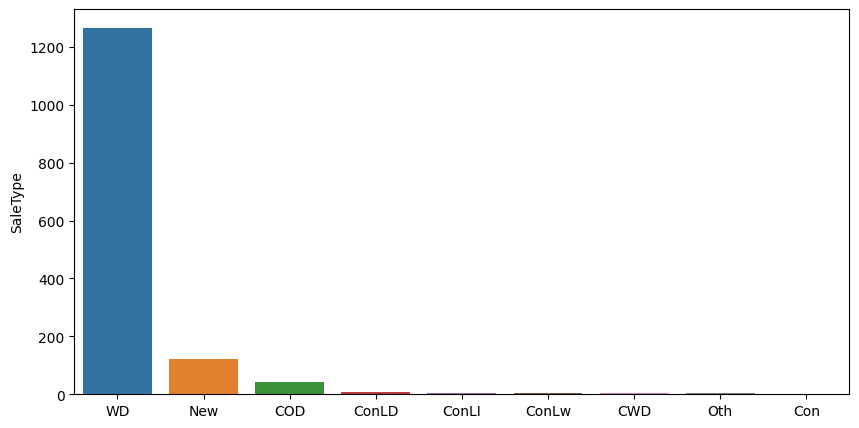

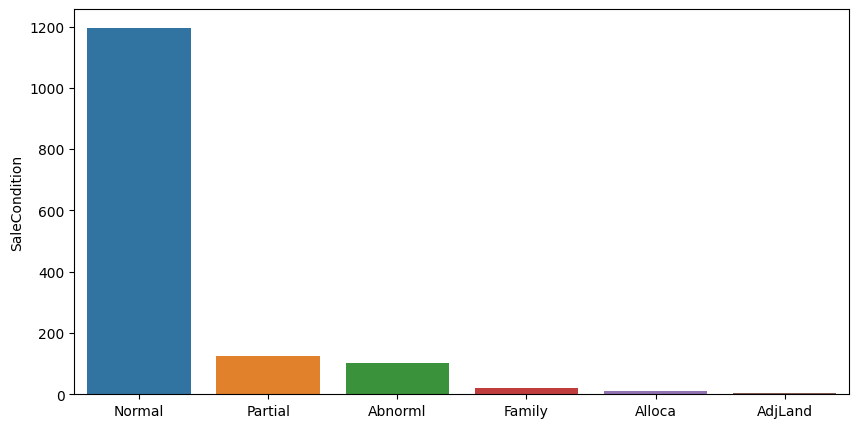

In [22]:
for col in df_cat.columns:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(x=df_cat[col].value_counts().index, y=df_cat[col].value_counts(), ax=ax)
    plt.show()

In [23]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(df_cat)
df_cat_ohe = pd.DataFrame(ohe.transform(df_cat), columns=ohe.get_feature_names_out(df_cat.columns), index=df_cat.index)
df_cat_ohe.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_NA,Alley_Pave,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Проверка после обработки

In [24]:
df_cat_ohe.shape, df_num_scale.shape

((1459, 267), (1459, 36))

In [25]:
df_cat_ohe.isna().sum().sum(), df_num_scale.isna().sum().sum()

(0, 0)

## Обучение моделей

### Разбиение на обучающую и тустовую выборки

In [26]:
X = pd.concat([df_num_scale, df_cat_ohe], axis=1)
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,0.073732,-0.229183,-0.207125,0.650852,-0.517424,1.051899,0.879449,0.513594,0.574748,-0.28876,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.871979,0.451896,-0.091909,-0.072372,2.178727,0.157540,-0.428864,-0.571009,1.171304,-0.28876,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.073732,-0.092967,0.073401,0.650852,-0.517424,0.985650,0.830993,0.325449,0.092239,-0.28876,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.310159,-0.456209,-0.096918,0.650852,-0.517424,-1.863050,-0.719600,-0.571009,-0.499931,-0.28876,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.073732,0.633517,0.374967,1.374077,-0.517424,0.952526,0.734081,1.365783,0.462893,-0.28876,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [27]:
y.max()

755000

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1021, 303), (1021,), (438, 303), (438,))

In [29]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
def cross_val(est, X, y, n_splits):
    cv = KFold(n_splits=n_splits)
    est = clone(est)
    train_errors = []
    test_errors = []
    X_s = np.array(X)
    y_s = np.array(y)
    for train_idx, val_idx in tqdm(cv.split(X_s)):
        X_train_cv, y_train_cv = X_s[train_idx], y_s[train_idx]
        X_val_cv, y_val_cv = X_s[val_idx], y_s[val_idx]
        est.fit(X_train_cv, y_train_cv)
        pred_train = est.predict(X_train_cv)
        pred_val = est.predict(X_val_cv)
        train_errors.append(
            mean_squared_error(y_train_cv, pred_train, squared=False)
        )
        test_errors.append(
            mean_squared_error(y_val_cv, pred_val, squared=False)
        )
    return (np.mean(train_errors), np.mean(test_errors), est)

### Линейная регрессия

Начнем с модели линейной регрессии и обучим ее на тренироочном датасете

In [30]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

Сделаем предсказания на тествовом датасете

In [31]:
y_pred_train_lr = lr.predict(X_train)
y_pred_test_lr = lr.predict(X_test)

Проверим качество модели на тренировочном и тестововм датасете. В качестве метрики будем использовать RMSE

In [32]:
from sklearn.metrics import mean_squared_error

rmse_train_lr = mean_squared_error(y_train, y_pred_train_lr) ** 0.5
rmse_test_lr = mean_squared_error(y_test, y_pred_test_lr) ** 0.5
rmse_train_lr, rmse_test_lr

(20096.42831101938, 141546207133414.03)

Мы видим на, что на тестовом датасете rmse на 9 порядков больше, чем rmse на тренировочном датасете. Попробуем применить кросс-валидацию для получения лучшего значения метрики

In [33]:
rmse_cv_train_lr, rmse_cv_test_lr, lr_cv = cross_val(lr, X, y, X.shape[0])
rmse_cv_train_lr, rmse_cv_test_lr

1459it [00:47, 30.43it/s]


(20519.47483061246, 12230536833307.55)

### Решающее дерево

Теперь построим решающее дерево, для задачи регрессии. Но для начала найдем наилучшие параметры модели для данной задачи

In [34]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr_param = {'max_depth' : np.arange(3, 27),
             'splitter' : ['best'],
             'criterion': ['squared_error']}

In [35]:
from sklearn.model_selection import GridSearchCV

dtr_grid = GridSearchCV(dtr, param_grid=dtr_param, verbose=10, n_jobs=-1)
dtr_grid.fit(X_train, y_train)
dtr = dtr_grid.best_estimator_
dtr_grid.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 3/5; 2/24] START criterion=squared_error, max_depth=4, splitter=best........[CV 1/5; 1/24] START criterion=squared_error, max_depth=3, splitter=best........
[CV 2/5; 2/24] START criterion=squared_error, max_depth=4, splitter=best........[CV 2/5; 1/24] START criterion=squared_error, max_depth=3, splitter=best........[CV 1/5; 2/24] START criterion=squared_error, max_depth=4, splitter=best........
[CV 4/5; 1/24] START criterion=squared_error, max_depth=3, splitter=best........
[CV 5/5; 1/24] START criterion=squared_error, max_depth=3, splitter=best........
[CV 3/5; 1/24] START criterion=squared_error, max_depth=3, splitter=best........



[CV 4/5; 1/24] END criterion=squared_error, max_depth=3, splitter=best;, score=0.369 total time=   0.0s
[CV 5/5; 1/24] END criterion=squared_error, max_depth=3, splitter=best;, score=0.694 total time=   0.0s
[CV 1/5; 1/24] END criterion=squared_error, max_depth=3, splitter=best;, score=0.6

{'criterion': 'squared_error', 'max_depth': 9, 'splitter': 'best'}

Обучим модельку

In [36]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=9)

Сделаем предсказания

In [37]:
y_pred_train_dtr = dtr.predict(X_train)
y_pred_test_dtr = dtr.predict(X_test)

In [38]:
from sklearn.metrics import mean_squared_error

rmse_train_dtr = mean_squared_error(y_train, y_pred_train_dtr) ** 0.5
rmse_test_dtr = mean_squared_error(y_test, y_pred_test_dtr) ** 0.5
rmse_train_dtr, rmse_test_dtr

(11450.07716187112, 38604.14607707641)

In [39]:
rmse_cv_train_dtr, rmse_cv_test_dtr, dtr_cv = cross_val(dtr, X, y, X.shape[0])

1459it [00:44, 33.13it/s]


In [40]:
rmse_cv_train_dtr, rmse_cv_test_dtr

(12911.469103946818, 23264.634059227526)

In [41]:
id(dtr), id(dtr_cv)

(5119225776, 5119223568)

### Случайный лес

In [42]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr_param = {'n_estimators' : np.arange(100, 500, 25),
             'max_depth' : np.arange(12, 18)}

In [ ]:
from sklearn.model_selection import GridSearchCV

rfr_grid = GridSearchCV(rfr, param_grid=rfr_param, n_jobs=-1, verbose=10)
rfr_grid.fit(X_train, y_train)
rfr = rfr_grid.best_estimator_
rfr_grid.best_params_

In [44]:
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=17, n_estimators=325)

In [45]:
y_pred_train_rfr = rfr.predict(X_train)
y_pred_test_rfr = rfr.predict(X_test)

In [46]:
from sklearn.metrics import mean_squared_error

rmse_train_rfr = mean_squared_error(y_train, y_pred_train_rfr) ** 0.5
rmse_test_rfr = mean_squared_error(y_test, y_pred_test_rfr) ** 0.5
rmse_train_rfr, rmse_test_rfr

(11034.545718766949, 29075.24029661611)

In [47]:
rmse_cv_train_rfr, rmse_cv_test_rfr, rfr_cv = cross_val(rfr, X, y, 100)

100it [14:18,  8.58s/it]


In [48]:
rmse_cv_train_rfr, rmse_cv_test_rfr

(10832.133133678513, 25842.219775338537)

### Ridge регрессия

In [49]:
from sklearn.linear_model import Ridge

r = Ridge()
r_param = {'alpha':np.linspace(0.0, 10.0, 100)}

In [ ]:
from sklearn.model_selection import GridSearchCV

r_grid = GridSearchCV(r, param_grid=r_param, n_jobs=-1, verbose=10)
r_grid.fit(X_train, y_train)
r = r_grid.best_estimator_
r_grid.best_params_

In [51]:
r.fit(X_train, y_train)

Ridge(alpha=10.0)

In [52]:
y_pred_train_r = r.predict(X_train)
y_pred_test_r = r.predict(X_test)

In [53]:
from sklearn.metrics import mean_squared_error

rmse_train_r = mean_squared_error(y_train, y_pred_train_r) ** 0.5
rmse_test_r = mean_squared_error(y_test, y_pred_test_r) ** 0.5
rmse_train_r, rmse_test_r

(22597.113885764673, 39895.33203333266)

In [54]:
rmse_cv_train_r, rmse_cv_test_r, r_cv = cross_val(r, X, y, X.shape[0])

1459it [00:17, 85.56it/s]


In [55]:
rmse_cv_train_r, rmse_cv_test_r

(24965.7269530264, 17551.291765606064)

### Сравнение метрик

In [56]:
df_metrics = pd.DataFrame({
    'model_name':
    [
        'Linear Regression',
        'Linear Regression',
        'Linear Regression',
        'Linear Regression',
        'Decision Tree',
        'Decision Tree',
        'Decision Tree',
        'Decision Tree',
        'Random Forest',
        'Random Forest',
        'Random Forest',
        'Random Forest',
        'Ridge Regression',
        'Ridge Regression',
        'Ridge Regression',
        'Ridge Regression'
    ],
    'name':
    [
        'train',
        'test',
        'train_cv',
        'test_cv',
        'train',
        'test',
        'train_cv',
        'test_cv',
        'train',
        'test',
        'train_cv',
        'test_cv',
        'train',
        'test',
        'train_cv',
        'test_cv',
    ],
    'value':
    [
        rmse_train_lr,
        rmse_test_lr,
        rmse_cv_train_lr, 
        rmse_cv_test_lr,
        rmse_train_dtr,
        rmse_test_dtr,
        rmse_cv_train_dtr, 
        rmse_cv_test_dtr,
        rmse_train_rfr,
        rmse_test_rfr,
        rmse_cv_train_rfr, 
        rmse_cv_test_rfr,
        rmse_train_r,
        rmse_test_r,
        rmse_cv_train_r, 
        rmse_cv_test_r
    ]})

<AxesSubplot:xlabel='model_name', ylabel='value'>

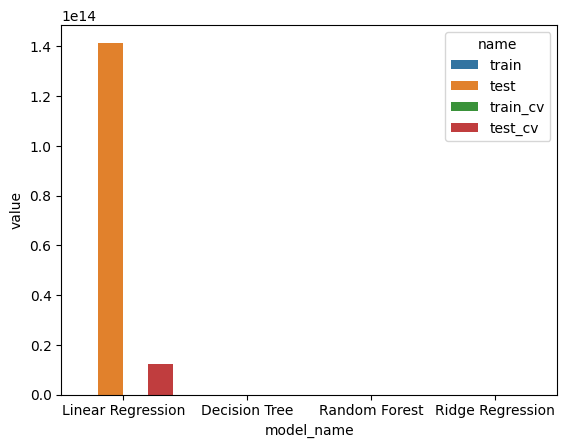

In [57]:
sns.barplot(data=df_metrics, x='model_name', y='value', hue='name')

Видим, что у линейной регрессии неадекватные значения метрики на тестовом датасете. Удалим из графика линейную регрессию

<AxesSubplot:xlabel='model_name', ylabel='value'>

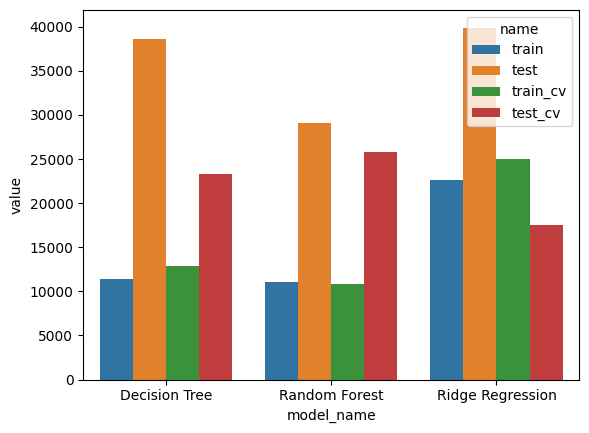

In [58]:
sns.barplot(data=df_metrics[df_metrics['model_name'] != 'Linear Regression'], x='model_name', y='value', hue='name')

### Ансамбли моделей

#### Бэггинг

In [59]:
from sklearn.ensemble import BaggingRegressor

br = BaggingRegressor(r, n_estimators=100, n_jobs=-1)
br.fit(X_train, y_train)

BaggingRegressor(base_estimator=Ridge(alpha=10.0), n_estimators=100, n_jobs=-1)

In [60]:
y_pred_train_br = br.predict(X_train)
y_pred_test_br = br.predict(X_test)

In [61]:
from sklearn.metrics import mean_squared_error

rmse_train_br = mean_squared_error(y_train, y_pred_train_br) ** 0.5
rmse_test_br = mean_squared_error(y_test, y_pred_test_br) ** 0.5
rmse_train_br, rmse_test_br

(23118.846258087706, 40265.42120245036)

In [62]:
rmse_cv_train_br, rmse_cv_test_br, br_cv = cross_val(br, X, y, 500)

500it [06:41,  1.24it/s]


In [63]:
rmse_cv_train_br, rmse_cv_test_br

(25603.92861589086, 20851.20656273)

#### Стекинг

In [64]:
from sklearn.ensemble import StackingRegressor

estimators = [
    ('r', r),
    ('dtr', dtr),
    ('rfr', rfr)
]

sr = StackingRegressor(estimators=estimators, n_jobs=-1)
sr.fit(X_train, y_train)

StackingRegressor(estimators=[('r', Ridge(alpha=10.0)),
                              ('dtr', DecisionTreeRegressor(max_depth=9)),
                              ('rfr',
                               RandomForestRegressor(max_depth=17,
                                                     n_estimators=325))],
                  n_jobs=-1)

In [65]:
y_pred_train_sr = sr.predict(X_train)
y_pred_test_sr = sr.predict(X_test)

In [66]:
from sklearn.metrics import mean_squared_error

rmse_train_sr = mean_squared_error(y_train, y_pred_train_sr) ** 0.5
rmse_test_sr = mean_squared_error(y_test, y_pred_test_sr) ** 0.5
rmse_train_sr, rmse_test_sr

(16305.540021966353, 33053.100195544466)

In [67]:
rmse_cv_train_sr, rmse_cv_test_sr, sr_cv = cross_val(sr, X, y, 50)

50it [26:24, 31.70s/it] 


In [68]:
rmse_cv_train_sr, rmse_cv_test_sr

(14066.86535922125, 26264.703505593356)

#### Бустинг

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

boost_data = pd.concat([df_num_scale, df_cat], axis='columns')
X_boost_train, x_boost_test, y_boost_train, y_boost_test = train_test_split(boost_data, y, test_size=0.3)
cbr = CatBoostRegressor(iterations=1000,
                           depth=10,
                           cat_features = np.arange(df_cat.shape[1]) + df_num_scale.shape[1],
                           verbose=True)
cbr.fit(X_boost_train, y_boost_train)

In [70]:
y_pred_train_cbr = cbr.predict(X_boost_train)
y_pred_test_cbr = cbr.predict(x_boost_test)

In [71]:
from sklearn.metrics import mean_squared_error

rmse_train_cbr = mean_squared_error(y_boost_train, y_pred_train_cbr) ** 0.5
rmse_test_cbr = mean_squared_error(y_boost_test, y_pred_test_cbr) ** 0.5
rmse_train_cbr, rmse_test_cbr

(7285.656964688335, 25646.300449153812)

In [ ]:
rmse_cv_train_cbr, rmse_cv_test_cbr, cbr_cv = cross_val(cbr, X_boost_train, y_boost_train, 10)

In [73]:
rmse_cv_train_cbr, rmse_cv_test_cbr

(9385.469638499771, 29028.26063269569)

### Сравнение метрик

#### Метрики ансамблей

In [74]:
df_ensemble_metrics = pd.DataFrame({
    'model_name':
    [
        'Bagging',
        'Bagging',
        'Bagging',
        'Bagging',
        'Stacking',
        'Stacking',
        'Stacking',
        'Stacking',
        'Boosting',
        'Boosting',
        'Boosting',
        'Boosting'
    ],
    'name':
    [
        'train',
        'test',
        'train_cv',
        'test_cv',
        'train',
        'test',
        'train_cv',
        'test_cv',
        'train',
        'test',
        'train_cv',
        'test_cv'
    ],
    'value':
    [
        rmse_train_br,
        rmse_test_br,
        rmse_cv_train_br, 
        rmse_cv_test_br,
        rmse_train_sr,
        rmse_test_sr,
        rmse_cv_train_sr, 
        rmse_cv_test_sr,
        rmse_train_cbr,
        rmse_test_cbr,
        rmse_cv_train_cbr, 
        rmse_cv_test_cbr
    ]})
df_ensemble_metrics

,model_name,name,value
0,Bagging,train,23118.846258
1,Bagging,test,40265.421202
2,Bagging,train_cv,25603.928616
3,Bagging,test_cv,20851.206563
4,Stacking,train,16305.540022
5,Stacking,test,33053.100196
6,Stacking,train_cv,14066.865359
7,Stacking,test_cv,26264.703506
8,Boosting,train,7285.656965
9,Boosting,test,25646.300449


<AxesSubplot:xlabel='model_name', ylabel='value'>

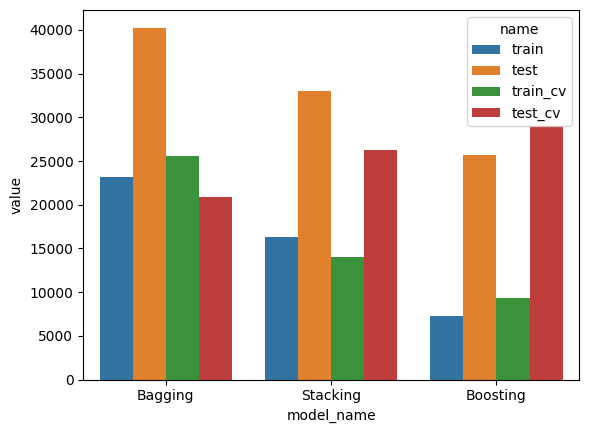

In [75]:
sns.barplot(data=df_ensemble_metrics, x='model_name', y='value', hue='name')

#### Общие метрики

In [76]:
df_all_metrics = pd.concat([df_metrics[df_metrics['model_name'] != 'Linear Regression'], df_ensemble_metrics], axis=0)
df_all_metrics.reset_index(drop=True)

,model_name,name,value
0,Decision Tree,train,11450.077162
1,Decision Tree,test,38604.146077
2,Decision Tree,train_cv,12911.469104
3,Decision Tree,test_cv,23264.634059
4,Random Forest,train,11034.545719
5,Random Forest,test,29075.240297
6,Random Forest,train_cv,10832.133134
7,Random Forest,test_cv,25842.219775
8,Ridge Regression,train,22597.113886
9,Ridge Regression,test,39895.332033


<AxesSubplot:xlabel='model_name', ylabel='value'>

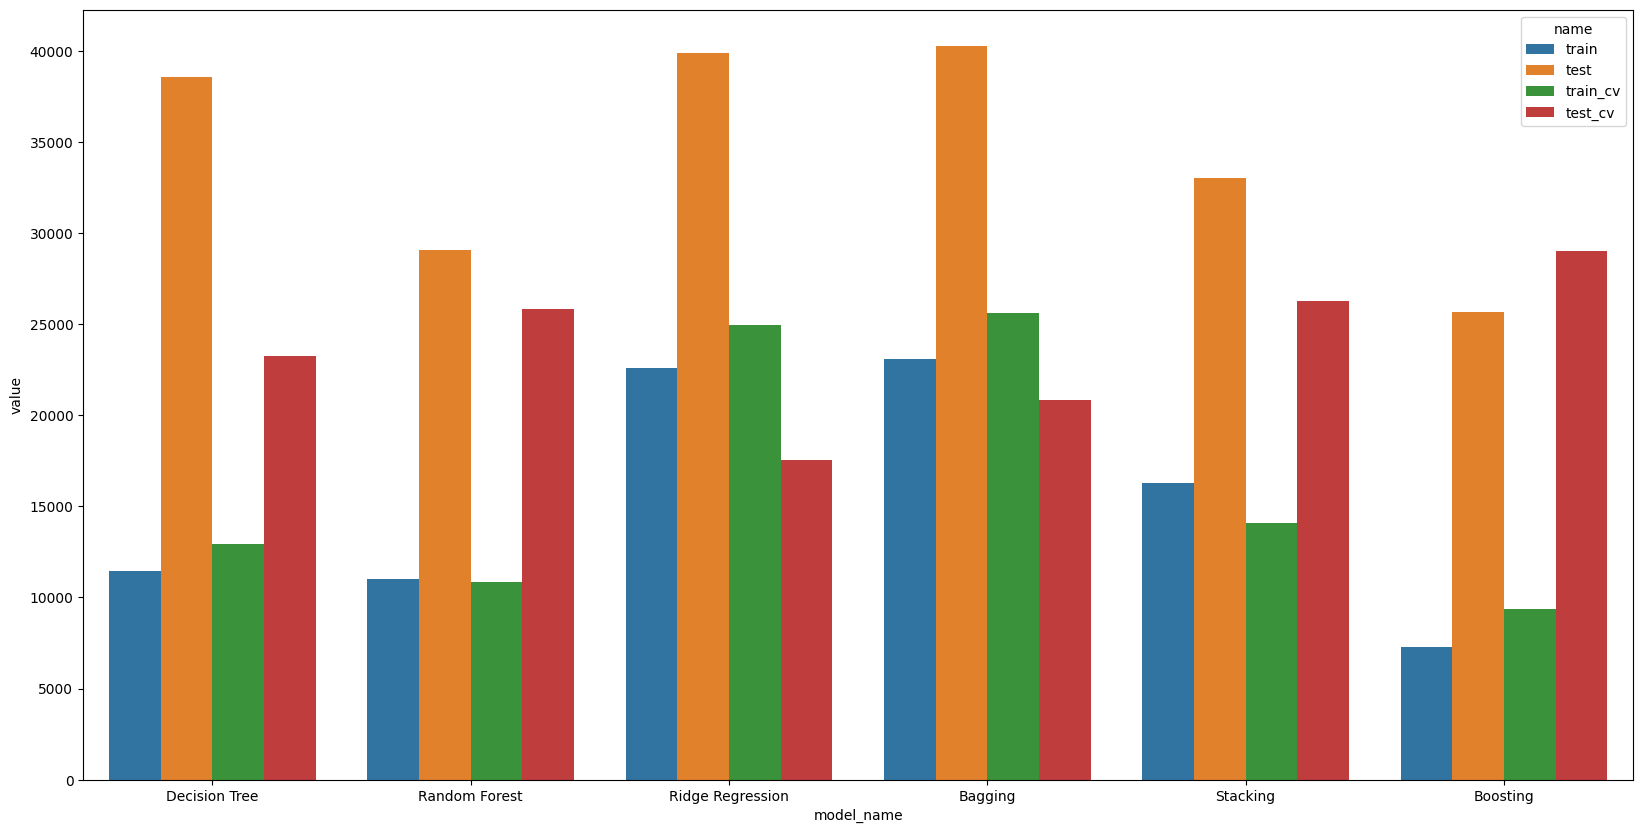

In [77]:
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=df_all_metrics, x='model_name', y='value', hue='name', ax=ax)

## Предсказания на тестовом датасете

### Предобработка

In [78]:
df_test = pd.read_csv('test.csv', index_col='Id')
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [79]:
na_col_test = df_test.isna().sum()[df_test.isna().sum() != 0].index
nan_df_test = pd.DataFrame(np.array([df_test[na_col_test].isna().sum(), df_test[na_col_test].dtypes]).T, index=na_col_test, columns=['sum', 'types']).sort_values(by='sum', ascending=False)
nan_df_test

,sum,types
PoolQC,1456,object
MiscFeature,1408,object
Alley,1352,object
Fence,1169,object
FireplaceQu,730,object
LotFrontage,227,float64
GarageCond,78,object
GarageYrBlt,78,float64
GarageQual,78,object
GarageFinish,78,object


In [80]:
col_rep_nan_test = ['PoolQC',
                    'MiscFeature',
                    'Alley',
                    'Fence',
                    'FireplaceQu',
                    'GarageType',
                    'GarageFinish',
                    'GarageQual',
                    'GarageCond',
                    'BsmtExposure',
                    'BsmtFinType2',
                    'BsmtFinType1',
                    'BsmtCond',
                    'BsmtQual' ]

In [81]:
df_test[col_rep_nan_test] = df_test[col_rep_nan_test].fillna('NA')

In [82]:
df_test['MasVnrType'].fillna('NA', inplace=True)
df_test['MasVnrArea'].fillna(0, inplace=True)

In [83]:
df_test['LotFrontage'].fillna(df_test['LotFrontage'].mean(), inplace=True)
df_test['TotalBsmtSF'].fillna(df_test['TotalBsmtSF'].mean(), inplace=True)
df_test['BsmtFinSF1'].fillna(df_test['BsmtFinSF1'].mean(), inplace=True)
df_test['BsmtFinSF2'].fillna(df_test['BsmtFinSF2'].mean(), inplace=True)
df_test['BsmtUnfSF'].fillna(df_test['BsmtUnfSF'].mean(), inplace=True)
df_test['Exterior1st'].fillna('Other', inplace=True)
df_test['Exterior2nd'].fillna('Other', inplace=True)
df_test['MSZoning'].fillna('C (all)', inplace=True)
df_test['Utilities'].fillna('AllPub', inplace=True)
df_test['Functional'].fillna('Typ', inplace=True)
df_test['KitchenQual'].fillna('TA', inplace=True)
df_test['SaleType'].fillna('Oth', inplace=True)
df_test['BsmtFullBath'].fillna(0, inplace=True)
df_test['BsmtHalfBath'].fillna(0, inplace=True)
df_test['GarageYrBlt'].fillna(0, inplace=True)
df_test['GarageCars'].fillna(0, inplace=True)
df_test['GarageArea'].fillna(0, inplace=True)

In [84]:
df_test.isna().sum()[df_test.isna().sum() != 0].index

Index([], dtype='object')

In [85]:
df_cat_test = df_test[cat_col]
df_num_test = df_test[num_col]

In [86]:
df_num_scale_test = pd.DataFrame(ss.fit_transform(df_num_test), index=df_num_test.index, columns=df_num_test.columns)
df_num_scale_test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1461,-0.874711,0.555587,0.363929,-0.751101,0.400766,-0.340945,-1.072885,-0.563316,0.063295,0.517348,...,1.185511,0.366678,-0.701628,-0.360738,-0.088827,1.818960,-0.057227,-0.092244,-0.038281,1.713905
1462,-0.874711,0.604239,0.897861,-0.054877,0.400766,-0.439695,-1.214908,0.047057,1.063392,-0.297903,...,-0.738518,2.347867,-0.178826,-0.360738,-0.088827,-0.301543,-0.057227,19.730438,-0.038281,1.713905
1463,0.061351,0.263676,0.809646,-0.751101,-0.497418,0.844059,0.678742,-0.563316,0.773254,-0.297903,...,0.043982,0.930495,-0.207871,-0.360738,-0.088827,-0.301543,-0.057227,-0.092244,-1.140614,1.713905
1464,0.061351,0.458284,0.032064,-0.054877,0.400766,0.876976,0.678742,-0.450284,0.357829,-0.297903,...,-0.011253,2.089451,-0.178826,-0.360738,-0.088827,-0.301543,-0.057227,-0.092244,-0.038281,1.713905
1465,1.465443,-1.244533,-0.971808,1.337571,-0.497418,0.679475,0.394694,-0.563316,-0.387298,-0.297903,...,0.154452,-0.729632,0.489198,-0.360738,-0.088827,2.243060,-0.057227,-0.092244,-1.875504,1.713905


In [87]:
df_cat_ohe_test = pd.DataFrame(ohe.transform(df_cat_test), columns=ohe.get_feature_names_out(df_cat_test.columns), index=df_cat_test.index)
df_cat_ohe_test.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_NA,Alley_Pave,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1461,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1462,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1463,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1464,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1465,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [88]:
X_test_test = pd.concat([df_num_scale_test, df_cat_ohe_test], axis='columns')
X_test_test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1461,-0.874711,0.555587,0.363929,-0.751101,0.400766,-0.340945,-1.072885,-0.563316,0.063295,0.517348,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1462,-0.874711,0.604239,0.897861,-0.054877,0.400766,-0.439695,-1.214908,0.047057,1.063392,-0.297903,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1463,0.061351,0.263676,0.809646,-0.751101,-0.497418,0.844059,0.678742,-0.563316,0.773254,-0.297903,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1464,0.061351,0.458284,0.032064,-0.054877,0.400766,0.876976,0.678742,-0.450284,0.357829,-0.297903,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1465,1.465443,-1.244533,-0.971808,1.337571,-0.497418,0.679475,0.394694,-0.563316,-0.387298,-0.297903,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Случайный лес

In [89]:
y_pred_test_test_rfr = rfr.predict(X_test_test)
ans_df = pd.DataFrame(y_pred_test_test_rfr, index=X_test_test.index, columns=['SalePrice'])
ans_df.index.name = 'Id'
ans_df.to_csv('pred_rfr.csv')

In [ ]:
y_pred_test_test_rfr_cv = rfr_cv.predict(X_test_test)
ans_df = pd.DataFrame(y_pred_test_test_rfr_cv, index=X_test_test.index, columns=['SalePrice'])
ans_df.index.name = 'Id'
ans_df.to_csv('pred_rfr_cv.csv')

### Ridge

In [91]:
y_pred_test_test_r = r.predict(X_test_test)
ans_df = pd.DataFrame(y_pred_test_test_r, index=X_test_test.index, columns=['SalePrice'])
ans_df.index.name = 'Id'
ans_df.to_csv('pred_r.csv')

In [ ]:
y_pred_test_test_r_cv = r_cv.predict(X_test_test)
ans_df = pd.DataFrame(y_pred_test_test_r_cv, index=X_test_test.index, columns=['SalePrice'])
ans_df.index.name = 'Id'
ans_df.to_csv('pred_r_cv.csv')

### Bagging

In [93]:
y_pred_test_test_br = br.predict(X_test_test)
ans_df = pd.DataFrame(y_pred_test_test_br, index=X_test_test.index, columns=['SalePrice'])
ans_df.index.name = 'Id'
ans_df.to_csv('pred_br.csv')

In [ ]:
y_pred_test_test_br_cv = br_cv.predict(X_test_test)
ans_df = pd.DataFrame(y_pred_test_test_br_cv, index=X_test_test.index, columns=['SalePrice'])
ans_df.index.name = 'Id'
ans_df.to_csv('pred_br_cv.csv')

### Stacking

In [95]:
y_pred_test_test_sr = sr.predict(X_test_test)
ans_df = pd.DataFrame(y_pred_test_test_sr, index=X_test_test.index, columns=['SalePrice'])
ans_df.index.name = 'Id'
ans_df.to_csv('pred_sr.csv')

In [ ]:
y_pred_test_test_sr_cv = sr_cv.predict(X_test_test)
ans_df = pd.DataFrame(y_pred_test_test_sr_cv, index=X_test_test.index, columns=['SalePrice'])
ans_df.index.name = 'Id'
ans_df.to_csv('pred_sr_cv.csv')

### Boosting

In [97]:
X_test_test_boost = pd.concat([df_num_scale_test, df_cat_test], axis='columns')
X_test_test_boost.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,-0.874711,0.555587,0.363929,-0.751101,0.400766,-0.340945,-1.072885,-0.563316,0.063295,0.517348,...,Attchd,Unf,TA,TA,Y,NA,MnPrv,NA,WD,Normal
1462,-0.874711,0.604239,0.897861,-0.054877,0.400766,-0.439695,-1.214908,0.047057,1.063392,-0.297903,...,Attchd,Unf,TA,TA,Y,NA,NA,Gar2,WD,Normal
1463,0.061351,0.263676,0.809646,-0.751101,-0.497418,0.844059,0.678742,-0.563316,0.773254,-0.297903,...,Attchd,Fin,TA,TA,Y,NA,MnPrv,NA,WD,Normal
1464,0.061351,0.458284,0.032064,-0.054877,0.400766,0.876976,0.678742,-0.450284,0.357829,-0.297903,...,Attchd,Fin,TA,TA,Y,NA,NA,NA,WD,Normal
1465,1.465443,-1.244533,-0.971808,1.337571,-0.497418,0.679475,0.394694,-0.563316,-0.387298,-0.297903,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal


In [98]:
y_pred_test_test_cbr = cbr.predict(X_test_test_boost)
ans_df = pd.DataFrame(y_pred_test_test_cbr, index=X_test_test_boost.index, columns=['SalePrice'])
ans_df.index.name = 'Id'
ans_df.to_csv('pred_cbr.csv')

In [99]:
y_pred_test_test_cbr_cv = cbr_cv.predict(X_test_test_boost)
ans_df = pd.DataFrame(y_pred_test_test_cbr_cv, index=X_test_test_boost.index, columns=['SalePrice'])
ans_df.index.name = 'Id'
ans_df.to_csv('pred_cbr_cv.csv')